Flow:

1. We first do exact schema clustering
2. Apply PPO within each cluster
3. Merge clusters one at a time to connect
    1. Use PPO First
    2. If schema match during merge, try join check
    3. 

In [51]:
from lineage import graphs, similarity
import networkx as nx

In [52]:
#BASE_DIR = '/media/suhail/Data/experiments/reexec/res/'
BASE_DIR = '/home/suhail/Projects/sample_workflows/azure_ml/'
#BASE_DIR = '/home/suhail/Projects/sample_workflows/million_notebooks/selected/'
#BASE_DIR = '/home/suhail/Projects/relic/primitives/python/generator/dataset/'

In [53]:
NB_NAME = 'retail'

In [54]:
import dataset as ds
import clustering


df_dict = ds.build_df_dict_dir(BASE_DIR+NB_NAME+'/artifacts/')
schema_dict = clustering.exact_schema_cluster(df_dict)
#df_dict
schema_dict

defaultdict(list,
            {frozenset({'atemp',
                        'cnt',
                        'holiday',
                        'hr',
                        'hum',
                        'mnth',
                        'season',
                        'temp',
                        'weathersit',
                        'weekday',
                        'windspeed',
                        'workingday',
                        'yr'}): ['v3.csv', 'v2.csv', 'v4.csv'],
             frozenset({'atemp',
                        'cnt',
                        'demand in hour -1',
                        'demand in hour -10',
                        'demand in hour -11',
                        'demand in hour -12',
                        'demand in hour -2',
                        'demand in hour -3',
                        'demand in hour -4',
                        'demand in hour -5',
                        'demand in hour -6',
                        'demand in hour 

In [55]:
df_dict['v2.csv'].head()

season  yr  mnth  hr  holiday  weekday  workingday  weathersit  temp  \
instant                                                                         
1             1   0     1   0        0        6           0           1  0.24   
2             1   0     1   1        0        6           0           1  0.22   
3             1   0     1   2        0        6           0           1  0.22   
4             1   0     1   3        0        6           0           1  0.24   
5             1   0     1   4        0        6           0           1  0.24   

          atemp   hum  windspeed  cnt  
instant                                
1        0.2879  0.81        0.0   16  
2        0.2727  0.80        0.0   40  
3        0.2727  0.80        0.0   32  
4        0.2879  0.75        0.0   13  
5        0.2879  0.75        0.0    1

In [56]:
import itertools
from collections import defaultdict
# Jaccard Distance First

#Duplicate function
def set_jaccard_distance(set1,set2):
    intersect = set1.intersection(set2)
    union = set1.union(set2)
    return 1-(len(intersect)/len(union))

def get_schema_distances(schemas):
    distance_dict = defaultdict(list)
    for combo in itertools.combinations(schemas.keys(),2):
        distance_dict[set_jaccard_distance(*combo)].append(combo)
    
    return distance_dict
    

In [57]:
candidates = get_schema_distances(schema_dict)
candidates

defaultdict(list,
            {0.52: [(frozenset({'atemp',
                          'cnt',
                          'holiday',
                          'hr',
                          'hum',
                          'mnth',
                          'season',
                          'temp',
                          'weathersit',
                          'weekday',
                          'windspeed',
                          'workingday',
                          'yr'}),
               frozenset({'atemp',
                          'cnt',
                          'demand in hour -1',
                          'demand in hour -10',
                          'demand in hour -11',
                          'demand in hour -12',
                          'demand in hour -2',
                          'demand in hour -3',
                          'demand in hour -4',
                          'demand in hour -5',
                          'demand in hour -6',
                  

In [58]:
def get_merge_candidates(schema_distances, threhsold=0.8):
    
    min_distance = min(schema_distances.keys())
    
    if min_distance > threshold:
        return None, schema_distances
    
    # Select lowest distance pair to merge at this stage
    min_schema_pairs = schema_distances[min_distance]
    
    merge_schema = min_schema_pairs.pop(0)
    
    # Remove if the min_schema_pairs is empty:
    if len(min_schema_pairs) == 0:
        del(schema_distances[min_distance])
    
    return merge_schema, schema_distances

In [59]:
def reverse_schema_dict(schema_dict):
    reverse_dict = {}
    for schema, artifact_list in schema_dict.items():
        for artifact in artifact_list:
            reverse_dict[artifact] = schema
            
    return reverse_dict

In [60]:
from lineage import similarity, graphs

def intra_cluster_similarity(df_dict, clusters, threshold=0.25):
    pairwise_jaccard = []
    for cluster in clusters.values():
        batch = {k: df_dict[k] for k in cluster}
        pw_batch = similarity.get_pairwise_similarity(batch, similarity.compute_jaccard_DF, threshold=threshold)
        pairwise_jaccard.extend(pw_batch)
    return pairwise_jaccard

In [61]:
%matplotlib inline  

In [62]:
img_frames = []

In [67]:
import os
import networkx as nx
import pandas as pd
import nppo


def lineage_inference_agglomerative(nb_name=NB_NAME, base_dir=BASE_DIR,
                      pre_cluster=False,
                      index=True, threshold=0.0001,
                      join_edges=False,
                      group_edges=False,
                      ):

    wf_dir = base_dir+nb_name

    if index:
        artifact_dir = wf_dir+'/artifacts/'
    else:
        artifact_dir = wf_dir+'/artifacts_1/'

    #Output Directory
    result_dir = wf_dir+'/inferred/'
    os.makedirs(result_dir, exist_ok=True)

    # Output Files
    schema_file = result_dir+'schema_matching.csv'
    row_file = result_dir+'row_matching.csv'
    cluster_file = result_dir+'clusters.csv'
    
    
    # Prepare Dataframe for results
    pr_df = pd.DataFrame(columns = ['nb_name', 'index', 'numclusters',  
                                    'distance_metric', 'edges_correct', 
                                    'edges_missing', 'edges_to_remove',
                                    'join_edges', 'precision', 'recall', 'F1',
                                    'missing_files'])

    

    # Load Dataset
    dataset = ds.build_df_dict_dir(artifact_dir)
    
    
    # Load Ground Truth:
    g_truth = nx.read_gpickle(wf_dir+'/'+nb_name+'_gt_fixed.pkl')
    
    
    # Compute all-pairs similarity for visualization
    # Start with intra-cluster edges:
    all_pairwise_jaccard = similarity.get_pairwise_similarity(dataset, similarity.compute_jaccard_DF)
    all_pw_jaccard_graph = graphs.generate_pairwise_graph(all_pairwise_jaccard)
       
    # Write out the Pairwise Distances as Adj list
    nx.to_pandas_adjacency(all_pw_jaccard_graph,weight='weight').to_csv(
                                                result_dir+'cell_sim.csv')
    
    
    # Check for files in the ground truth that are missing in file list
    missing_files = ds.check_csv_graph(artifact_dir, g_truth)

    # Cluster for visualization
    clusters = clustering.exact_schema_cluster(dataset)
    clustering.write_clusters_to_file(clusters, result_dir+'clusters_with_filename.csv')

    # Start with intra-cluster edges:
    pairwise_jaccard = intra_cluster_similarity(dataset, clusters)

    pw_jaccard_graph = graphs.generate_pairwise_graph(pairwise_jaccard)

    
   

    g_inferred = graphs.generate_spanning_tree(pw_jaccard_graph)
    
    
    # Add vertices to the graph if they don't exist
    for artifact in dataset.keys():
        if artifact not in [n for n in g_inferred.nodes()]:
            print('Adding artifact to graph', artifact)
            g_inferred.add_node(artifact)
    
    
    
    nx.write_edgelist(g_inferred,result_dir+'infered_mst_cell.csv',data=True)
    
    #Draw first graph and get results
    cluster_dict = clustering.get_graph_clusters(result_dir+'clusters_with_filename.csv')
    img_frames.append(graphs.generate_and_draw_graph(base_dir, nb_name, 'cell', cluster_dict=cluster_dict, join_list=None))
    

    result = graphs.get_precision_recall(g_truth,g_inferred)
        
    pr_df = pr_df.append({
        'nb_name': nb_name,
        'index': index,
        'numclusters': len(clusters),
        'distance_metric': 'pandas_cell',
        'edges_correct': len(result['correct_edges']),
        'edges_missing': len(result['to_add']),
        'edges_to_remove': len(result['to_remove']),
        #'join_edges': len(inferred_j_edges),
        'precision': result['Precision'],
        'recall': result['Recall'],
        'F1': result['F1'],
        'missing_files': len(missing_files)
    }, ignore_index=True)
    
    # Write out inferred graph
    #nx.write_edgelist(g_inferred,result_dir+'infered_mst_cell.csv',data=True)
    
    components = [c for c in nx.connected_components(g_inferred)]
    print('Components:', components)
    
    steps = 0
    stop = False

    #Clustering Loop Starts here
    while(len(components) > 1 and steps < 20 and not stop):
        
        steps += 1
        
        new_graph = find_components_join_edge(g_inferred, dataset, pw_graph=all_pw_jaccard_graph)
        if not new_graph:
            stop = True
        else:
            g_inferred = new_graph 
        
        components = [c for c in nx.connected_components(g_inferred)]
        print('Components:', components)
        
        
        nx.write_edgelist(g_inferred,result_dir+'infered_mst_cell.csv',data=True)
        
        
        # Draw inferred graph image:
        if(len(clusters) > 1):
            clustering.write_clusters_to_file(clusters, result_dir+'clusters_with_filename.csv')
            cluster_dict = clustering.get_graph_clusters(result_dir+'clusters_with_filename.csv')
        else:
            cluster_dict = None
        img_frames.append(graphs.generate_and_draw_graph(base_dir, nb_name, 'cell', cluster_dict=cluster_dict, join_list=None))
    
    
        #Compute PR after merge
        
        result = graphs.get_precision_recall(g_truth,g_inferred)
        
        pr_df = pr_df.append({
            'nb_name': nb_name,
            'index': index,
            'numclusters': len(components),
            'distance_metric': 'pandas_cell',
            'edges_correct': len(result['correct_edges']),
            'edges_missing': len(result['to_add']),
            'edges_to_remove': len(result['to_remove']),
            #'join_edges': len(inferred_j_edges),
            'precision': result['Precision'],
            'recall': result['Recall'],
            'F1': result['F1'],
            'missing_files': len(missing_files)
        }, ignore_index=True)
            

    # Test for NPPOs:
    
    inferred_j_edges = []
    join_list = None
    cluster_dict = None

    if join_edges:
        print('Writing Cluster File')

        print("Adding Join Edges")
        join_list = nppo.find_all_joins_df_dict(dataset)
        print(len(join_list), "Joins Detected")
        g_inferred = nppo.add_join_edges(join_list, g_inferred)


        for join in join_list:
            inferred_j_edges.append((join[0], join[2]))
            inferred_j_edges.append((join[1], join[2]))


        nppo.write_join_candidates(join_list, result_dir+'join_candidates.csv')

        g_truth_j_edges = [(u,v) for u,v,d in g_truth.edges(data=True) \
                           if g_truth[u][v]['operation'] == 'merge' ]

        #Check Join Precision/Recall
        #print(get_join_precision_recall(g_truth_j_edges, inferred_j_edges))
        
        result = graphs.get_precision_recall(g_truth,g_inferred)

        cluster_dict = clustering.get_graph_clusters(result_dir+'clusters_with_filename.csv')
        img_frames.append(graphs.generate_and_draw_graph(base_dir, nb_name, 'cell', cluster_dict=cluster_dict, join_list=join_list))

        pr_df = pr_df.append({
            'nb_name': nb_name,
            'index': index,
            'numclusters': len(clusters),
            'distance_metric': 'pandas_cell',
            'edges_correct': len(result['correct_edges']),
            'edges_missing': len(result['to_add']),
            'edges_to_remove': len(result['to_remove']),
            'join_edges': len(inferred_j_edges),
            'precision': result['Precision'],
            'recall': result['Recall'],
            'F1': result['F1'],
            'missing_files': len(missing_files)
        }, ignore_index=True)
  
    return pr_df

In [64]:
def generate_score_dict(pairscores):
    returndict = defaultdict(list)
    for src,dst,score in pairscores:
        returndict[score].append((src,dst,score))
    return returndict

In [65]:

def tiebreak_pairscores(df_dict, pairlist):
    max_pair = None
    max_raw_score = 0.0
    
    for src,dst,score in pairlist:
        srcdf = df_dict[src]
        dstdf = df_dict[dst]
        overlap_score = similarity.compute_DF_overlap(srcdf,dstdf)
        
        if overlap_score > max_raw_score:
            max_pair = (src,dst,score)
            max_raw_score = overlap_score
            
    return max_pair
        

In [66]:
import numpy as np

def find_components_join_edge(g_inferred, df_dict, pw_graph=None):
    schema_dict = clustering.exact_schema_cluster(df_dict)
    
    a_schema_dict = reverse_schema_dict(schema_dict)
    
    components = [c for c in nx.connected_components(g_inferred)]
    
    all_cmp_pairs_similarties = []
    
    for srccmp, dstcmp in itertools.combinations(components, 2):
        similarites = similarity.get_pairs_similarity(df_dict, srccmp, dstcmp)
        all_cmp_pairs_similarties.extend(similarites)
        
    
    all_cmp_pairs_similarties.sort(key=lambda x: x[2], reverse=True)
    
    score_dict = generate_score_dict(all_cmp_pairs_similarties)
    
    maxscore = max(score_dict)
    
    if maxscore > 0.001:
        if len(score_dict[maxscore]) > 1:
            src, dst, score = tiebreak_pairscores(df_dict, score_dict[maxscore])
        else:
            src, dst, score = score_dict[maxscore][0]
        
        print('Adding edge', src, dst, score)
        g_inferred.add_edge(src, dst, weight=score)
        return g_inferred
    
    else:
        return None

    

In [68]:
NB_NAME = 'retail'

Adding artifact to graph v11-s.csv
Adding artifact to graph v20.csv
Adding artifact to graph v19.csv
Adding artifact to graph v14.csv
Adding artifact to graph v10.csv
Adding artifact to graph v1.csv
Adding artifact to graph v5.csv
Adding artifact to graph v15.csv
Adding artifact to graph v6.csv
None

v1.csv


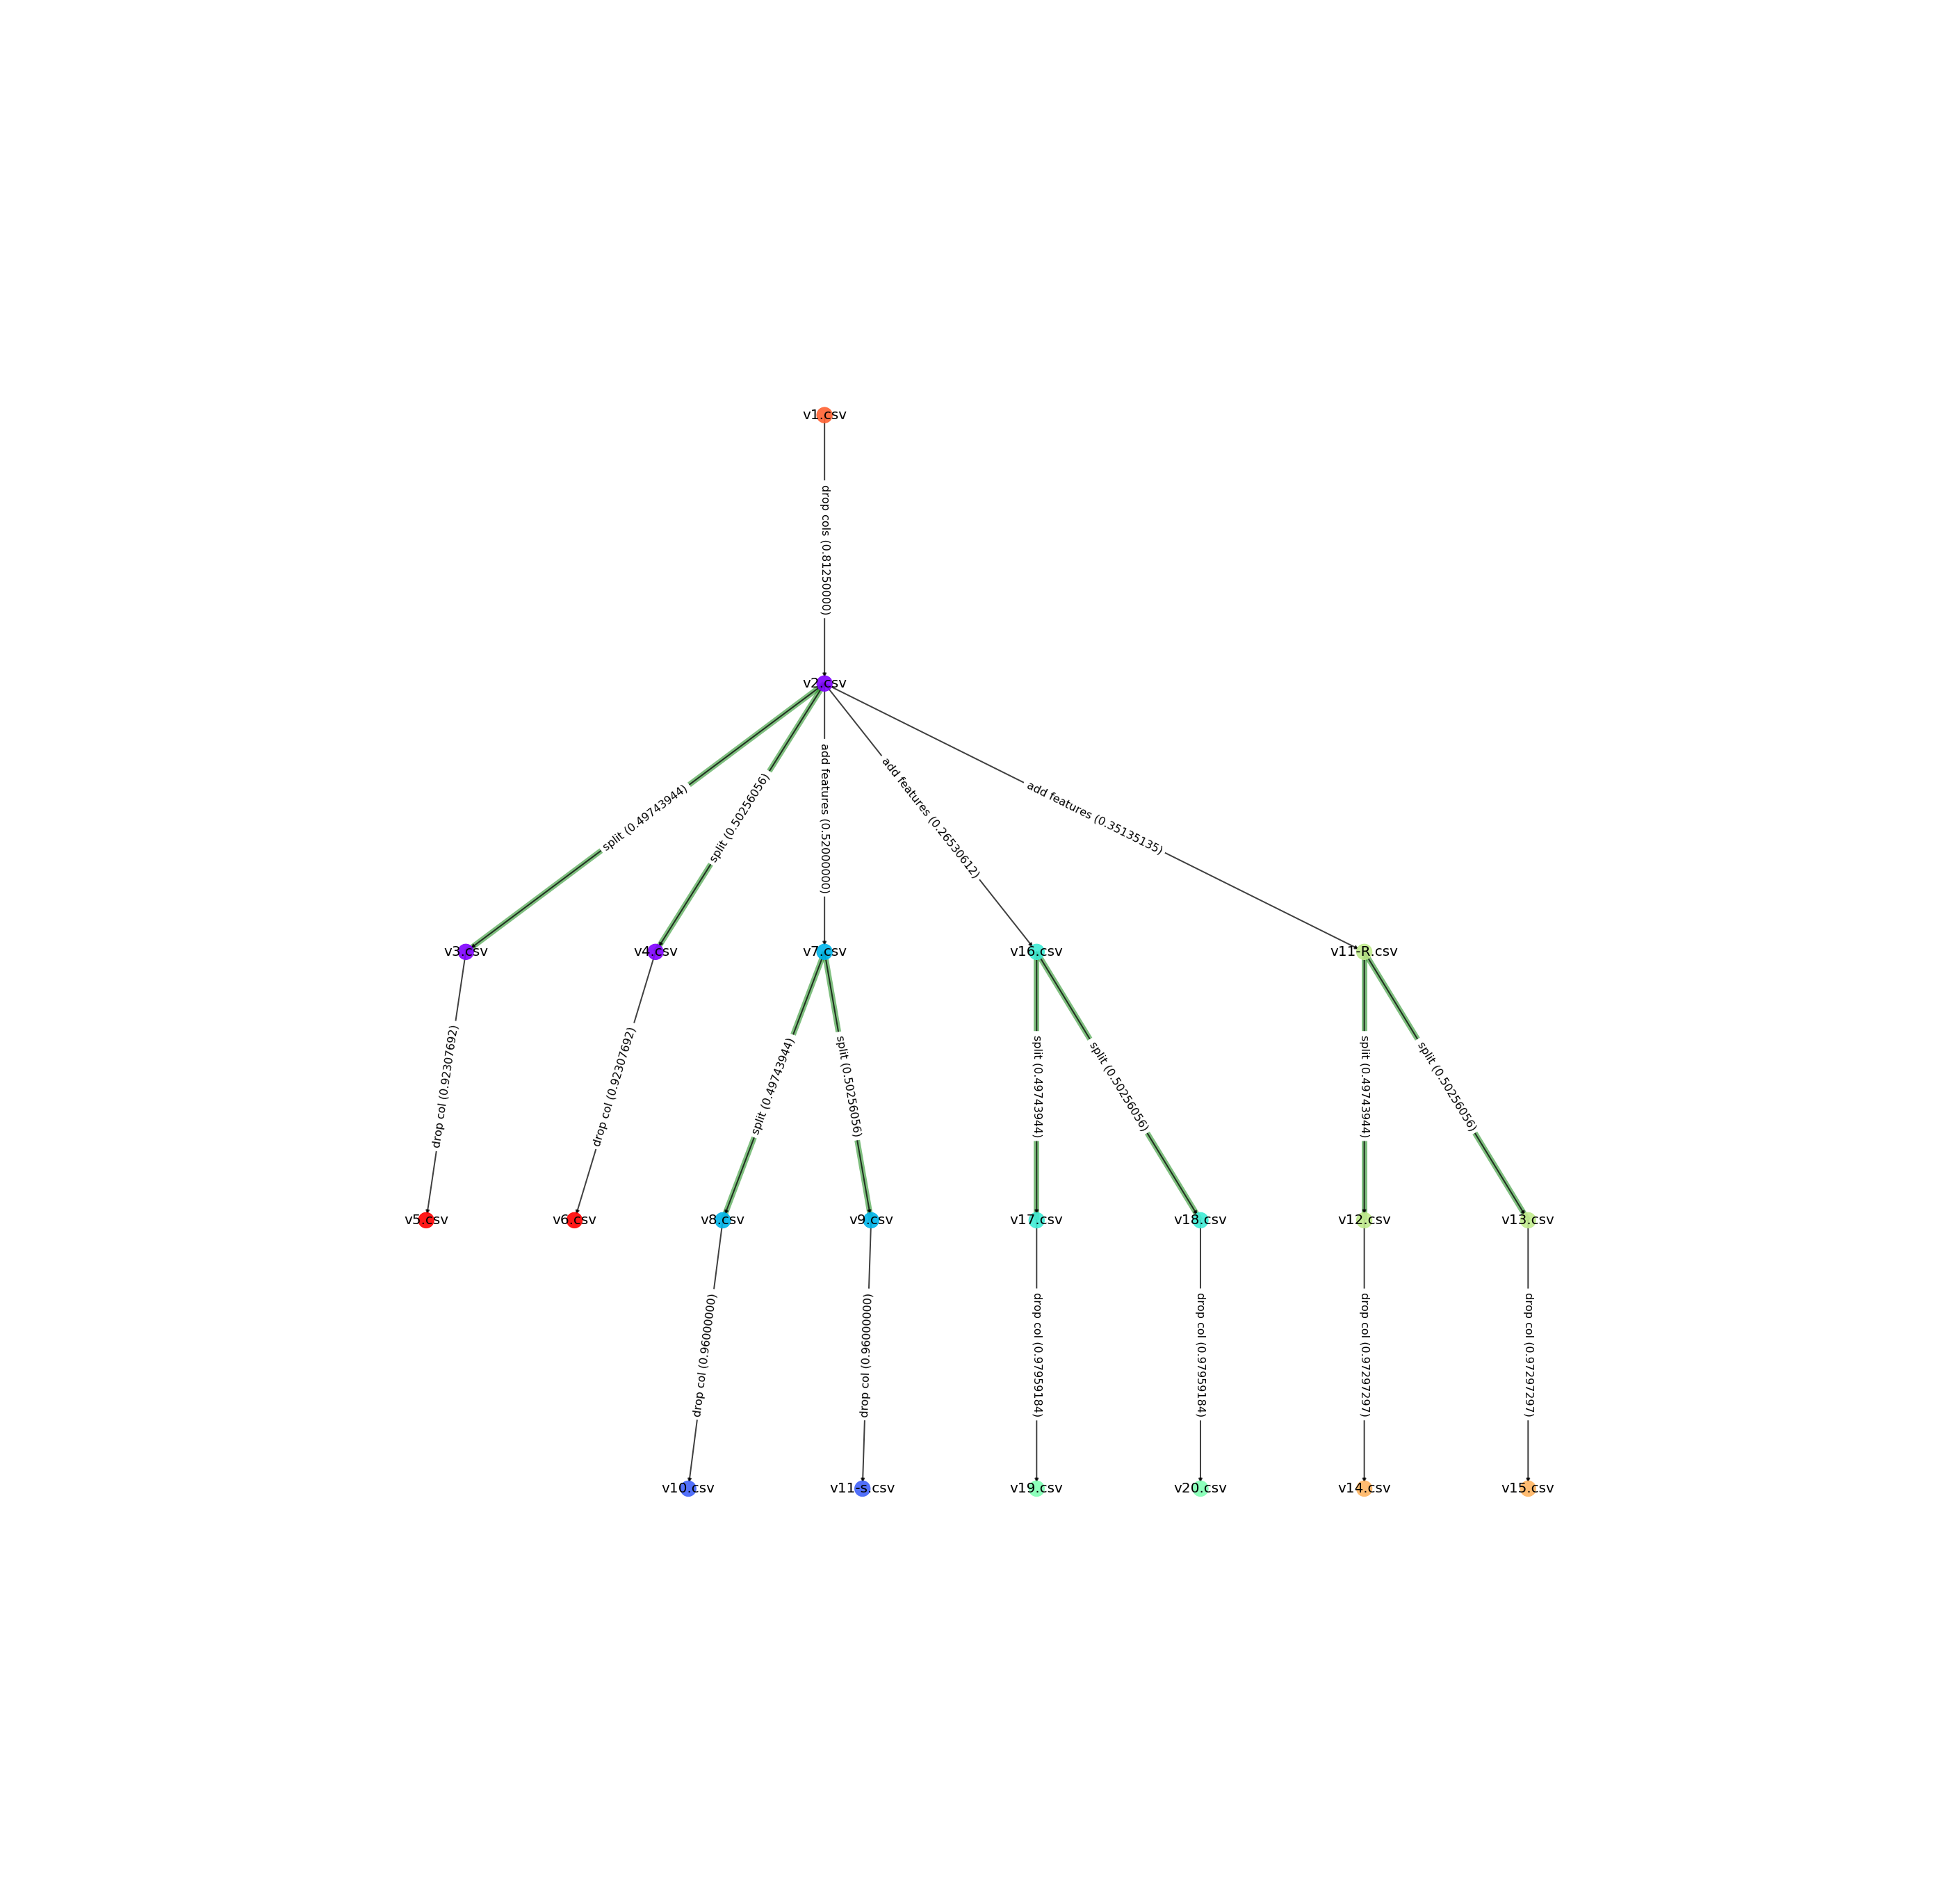

Components: [{'v4.csv', 'v2.csv', 'v3.csv'}, {'v7.csv', 'v9.csv', 'v8.csv'}, {'v16.csv', 'v17.csv', 'v18.csv'}, {'v11-R.csv', 'v13.csv', 'v12.csv'}, {'v11-s.csv'}, {'v20.csv'}, {'v19.csv'}, {'v14.csv'}, {'v10.csv'}, {'v1.csv'}, {'v5.csv'}, {'v15.csv'}, {'v6.csv'}]


Adding edge v18.csv v20.csv 0.9795918367346939
Components: [{'v4.csv', 'v2.csv', 'v3.csv'}, {'v7.csv', 'v9.csv', 'v8.csv'}, {'v16.csv', 'v17.csv', 'v20.csv', 'v18.csv'}, {'v11-R.csv', 'v13.csv', 'v12.csv'}, {'v11-s.csv'}, {'v19.csv'}, {'v14.csv'}, {'v10.csv'}, {'v1.csv'}, {'v5.csv'}, {'v15.csv'}, {'v6.csv'}]
None

v1.csv


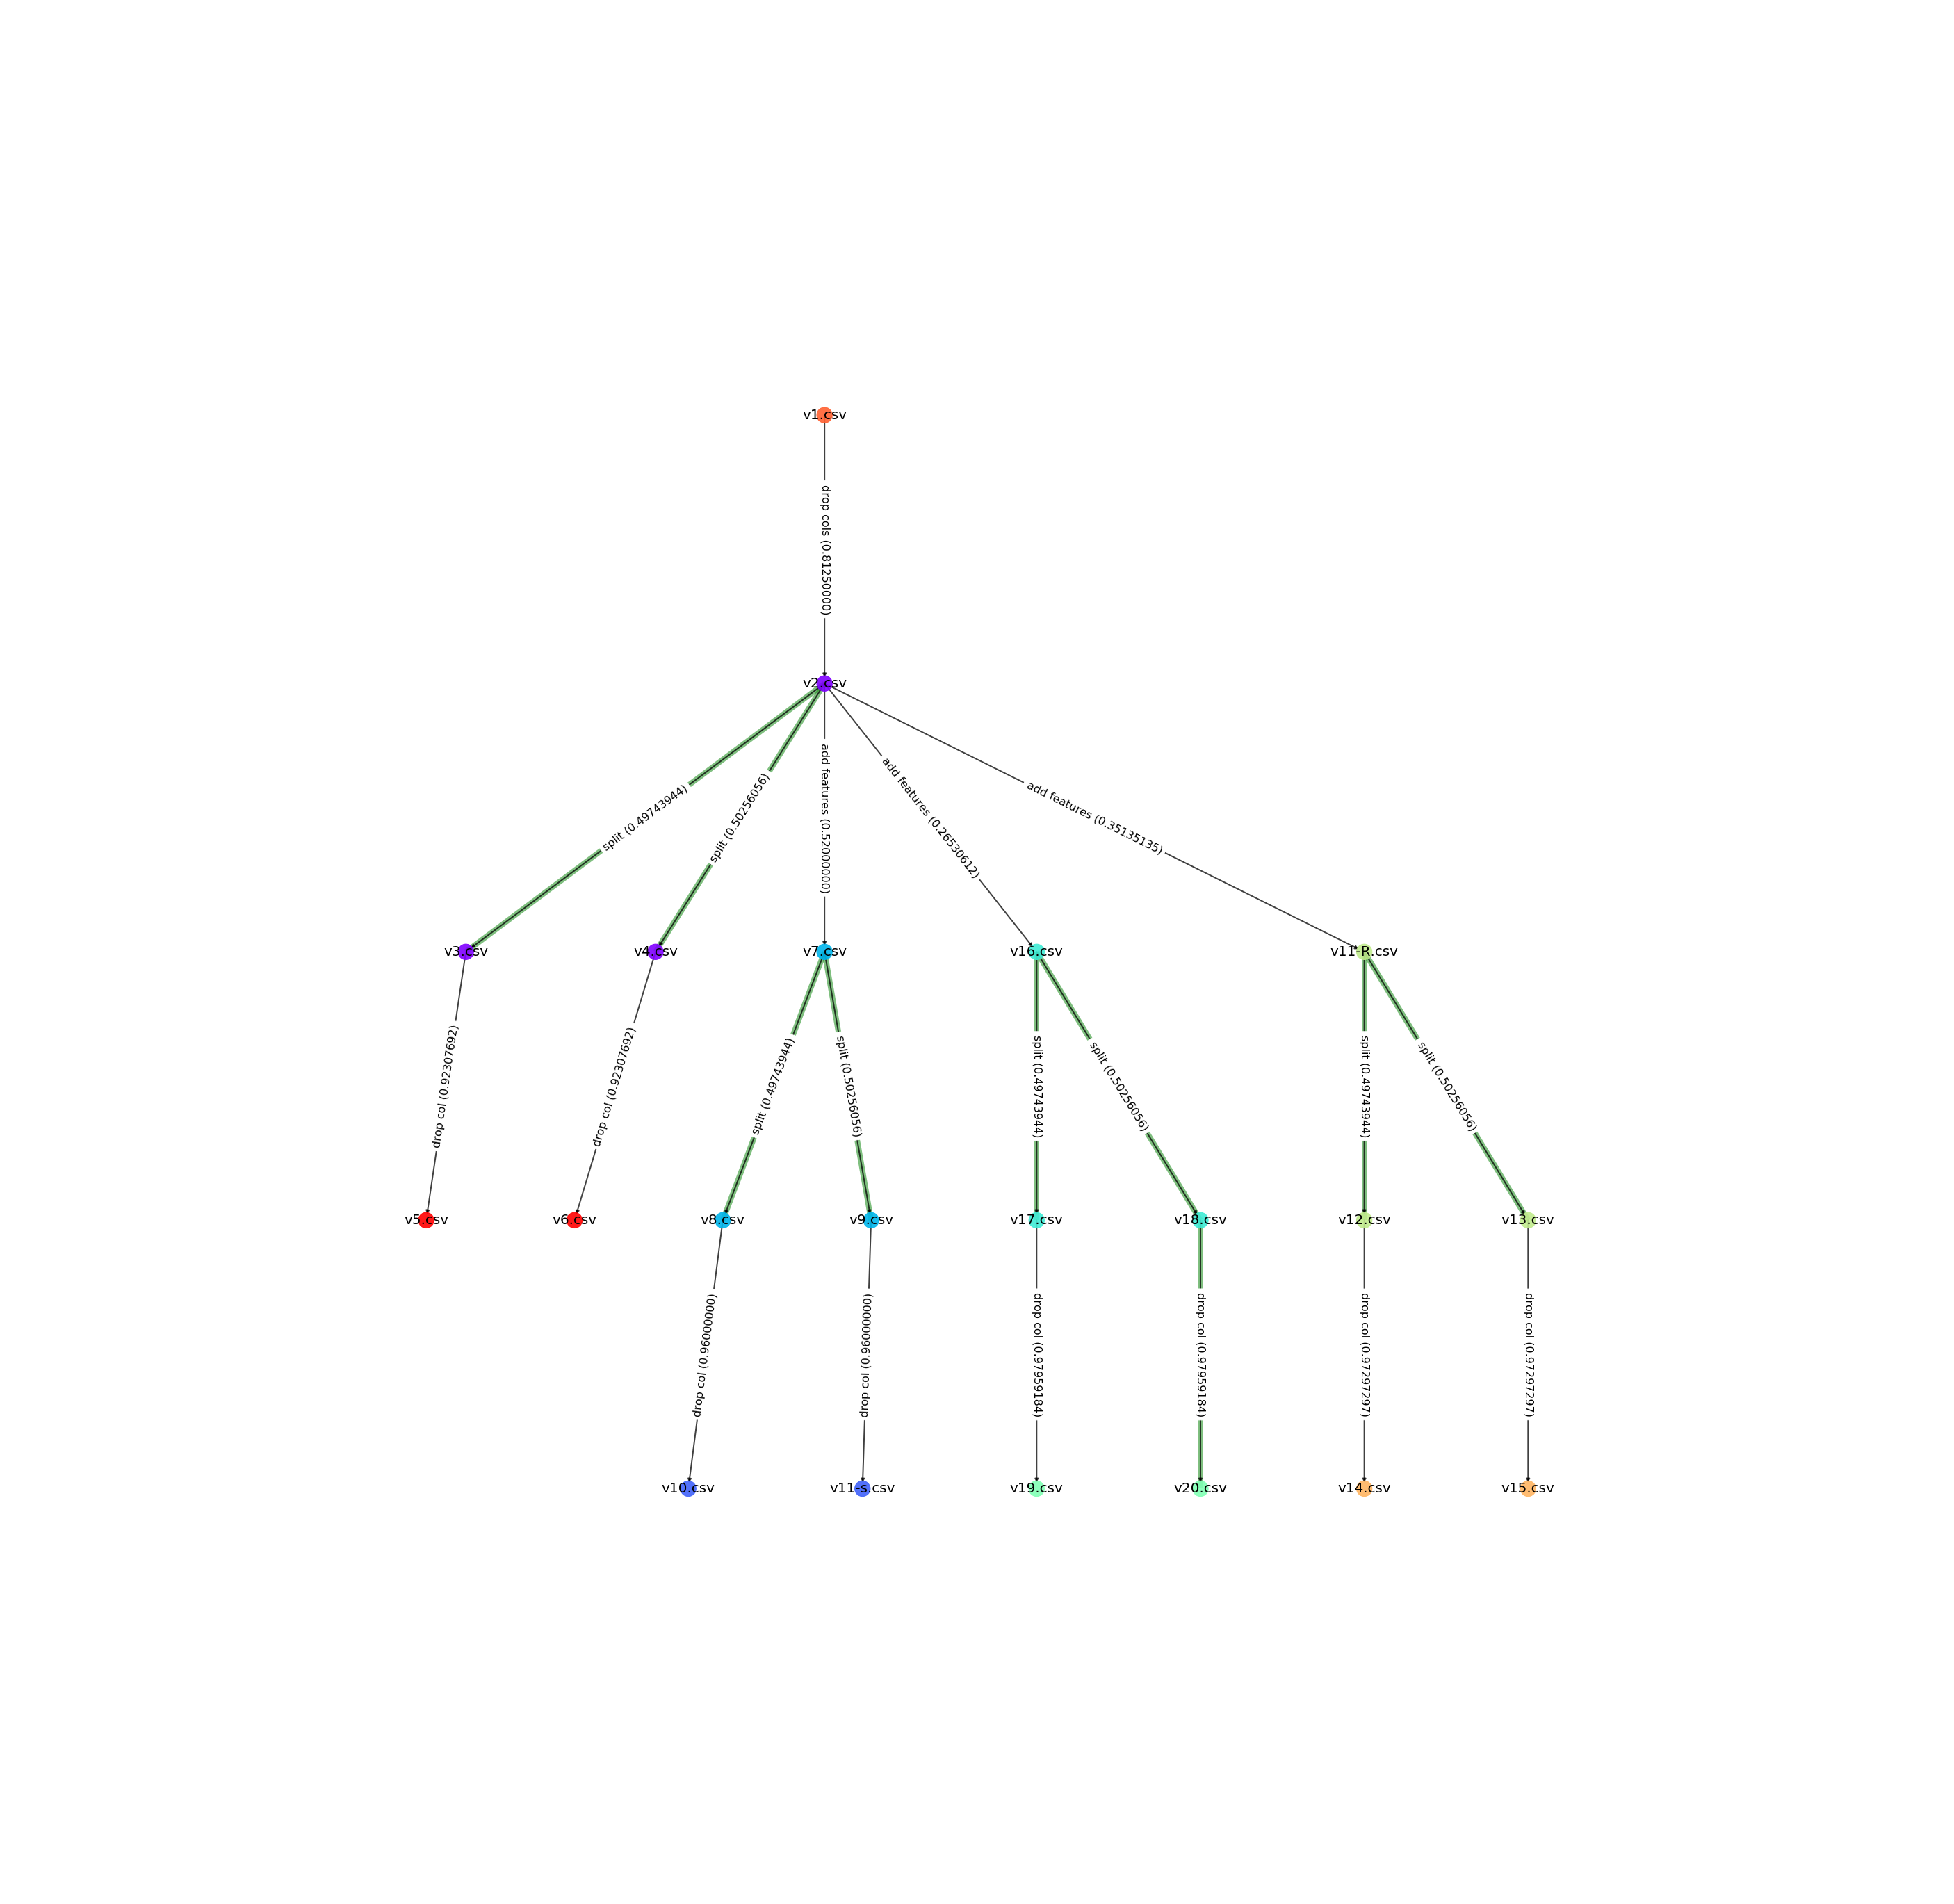

Adding edge v17.csv v19.csv 0.9795918367346939
Components: [{'v4.csv', 'v2.csv', 'v3.csv'}, {'v7.csv', 'v9.csv', 'v8.csv'}, {'v16.csv', 'v18.csv', 'v19.csv', 'v17.csv', 'v20.csv'}, {'v11-R.csv', 'v13.csv', 'v12.csv'}, {'v11-s.csv'}, {'v14.csv'}, {'v10.csv'}, {'v1.csv'}, {'v5.csv'}, {'v15.csv'}, {'v6.csv'}]
None

v1.csv


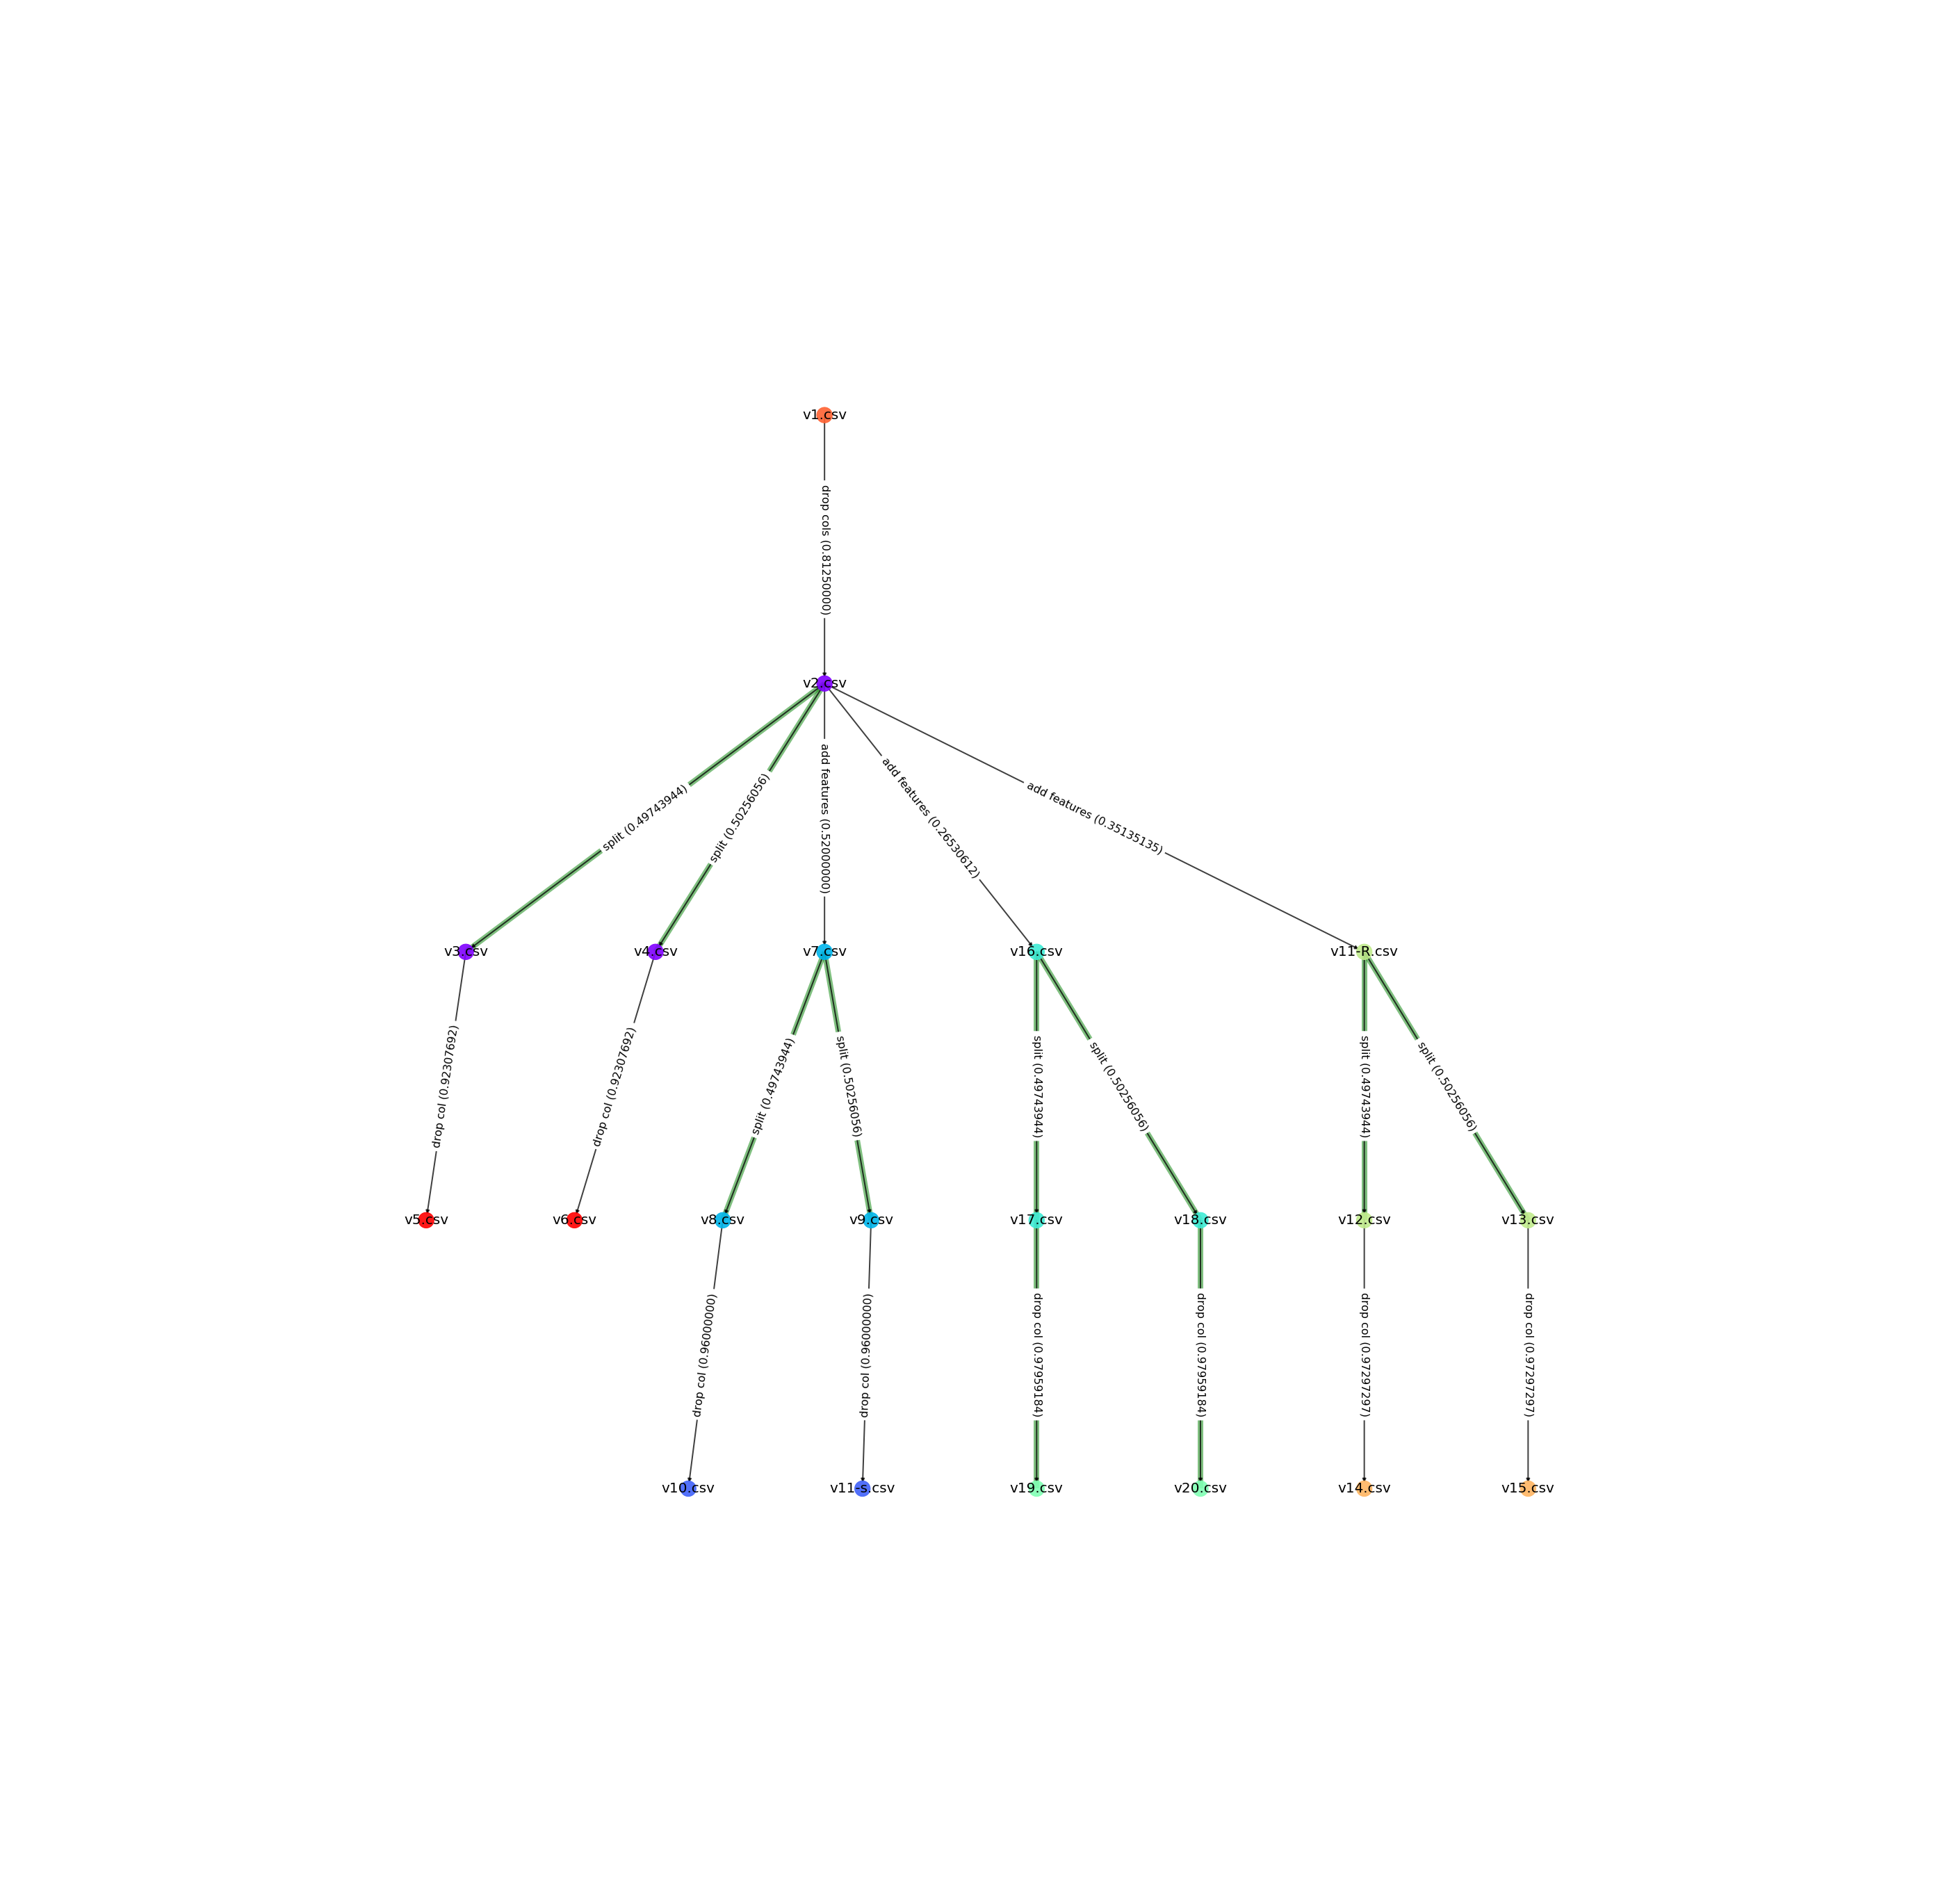

Adding edge v13.csv v15.csv 0.972972972972973
Components: [{'v4.csv', 'v2.csv', 'v3.csv'}, {'v7.csv', 'v9.csv', 'v8.csv'}, {'v16.csv', 'v18.csv', 'v19.csv', 'v17.csv', 'v20.csv'}, {'v11-R.csv', 'v13.csv', 'v12.csv', 'v15.csv'}, {'v11-s.csv'}, {'v14.csv'}, {'v10.csv'}, {'v1.csv'}, {'v5.csv'}, {'v6.csv'}]
None

v1.csv


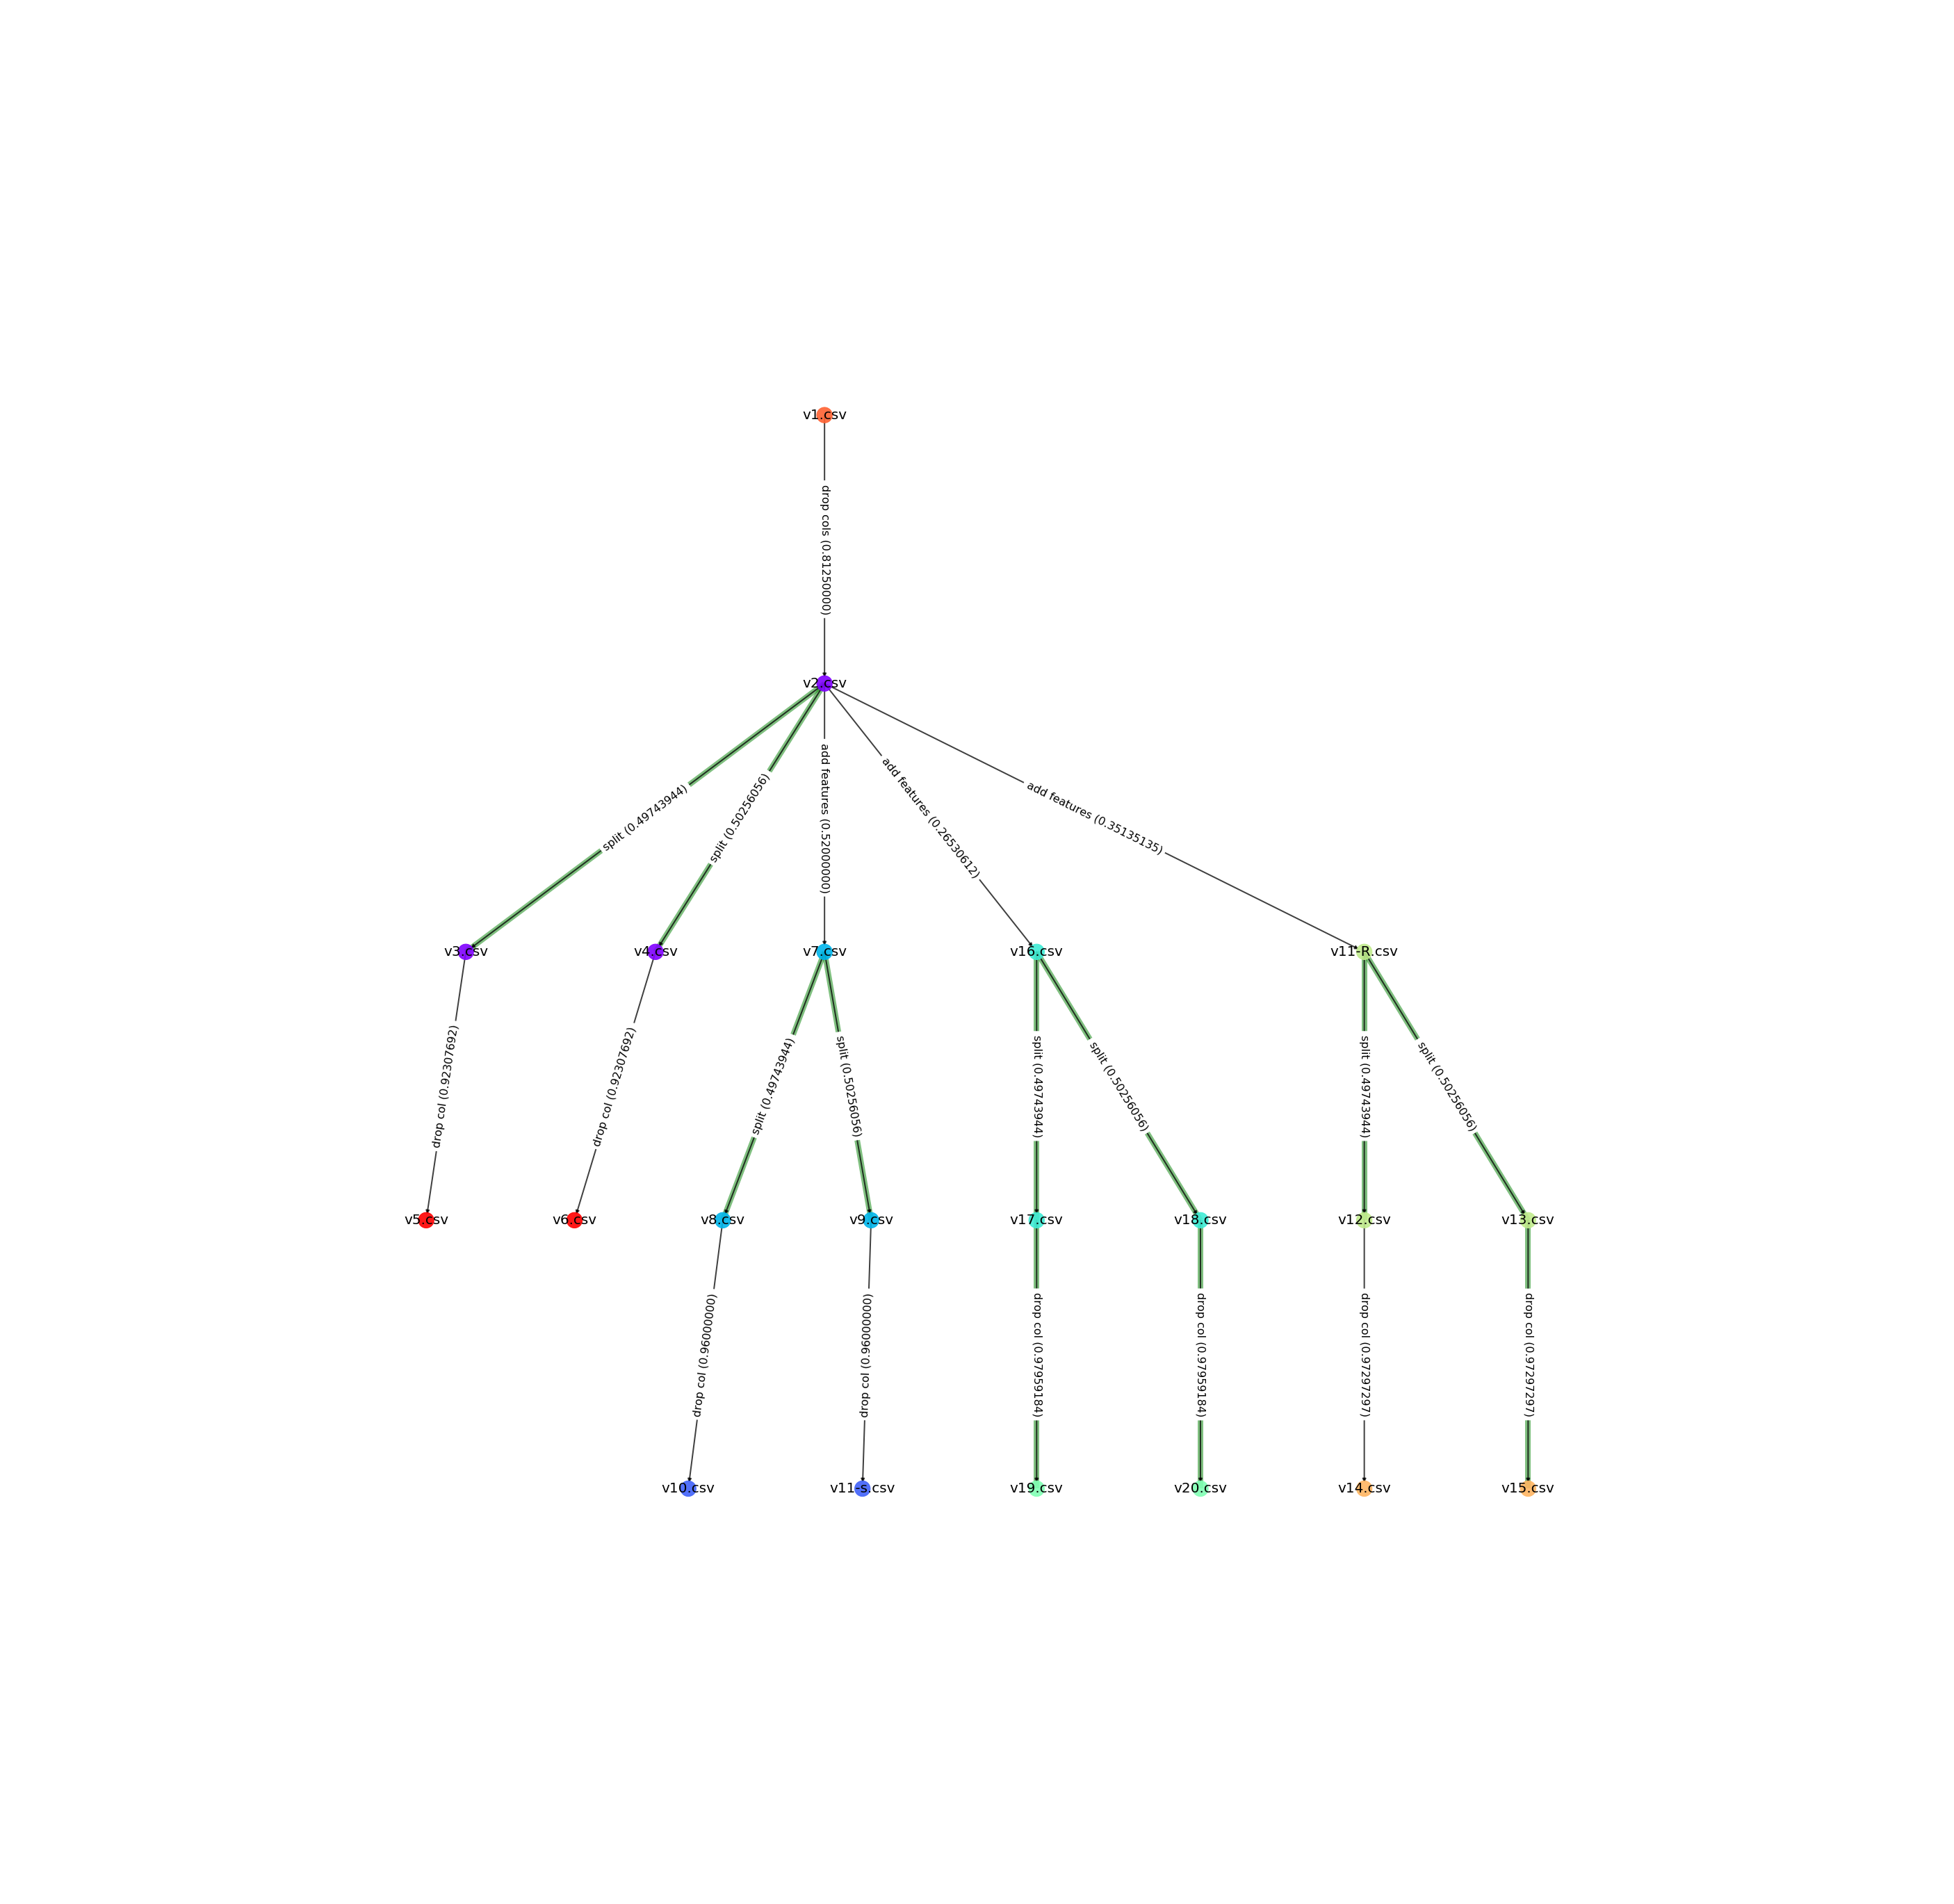

Adding edge v12.csv v14.csv 0.972972972972973
Components: [{'v4.csv', 'v2.csv', 'v3.csv'}, {'v7.csv', 'v9.csv', 'v8.csv'}, {'v16.csv', 'v18.csv', 'v19.csv', 'v17.csv', 'v20.csv'}, {'v13.csv', 'v14.csv', 'v12.csv', 'v15.csv', 'v11-R.csv'}, {'v11-s.csv'}, {'v10.csv'}, {'v1.csv'}, {'v5.csv'}, {'v6.csv'}]
None

v1.csv


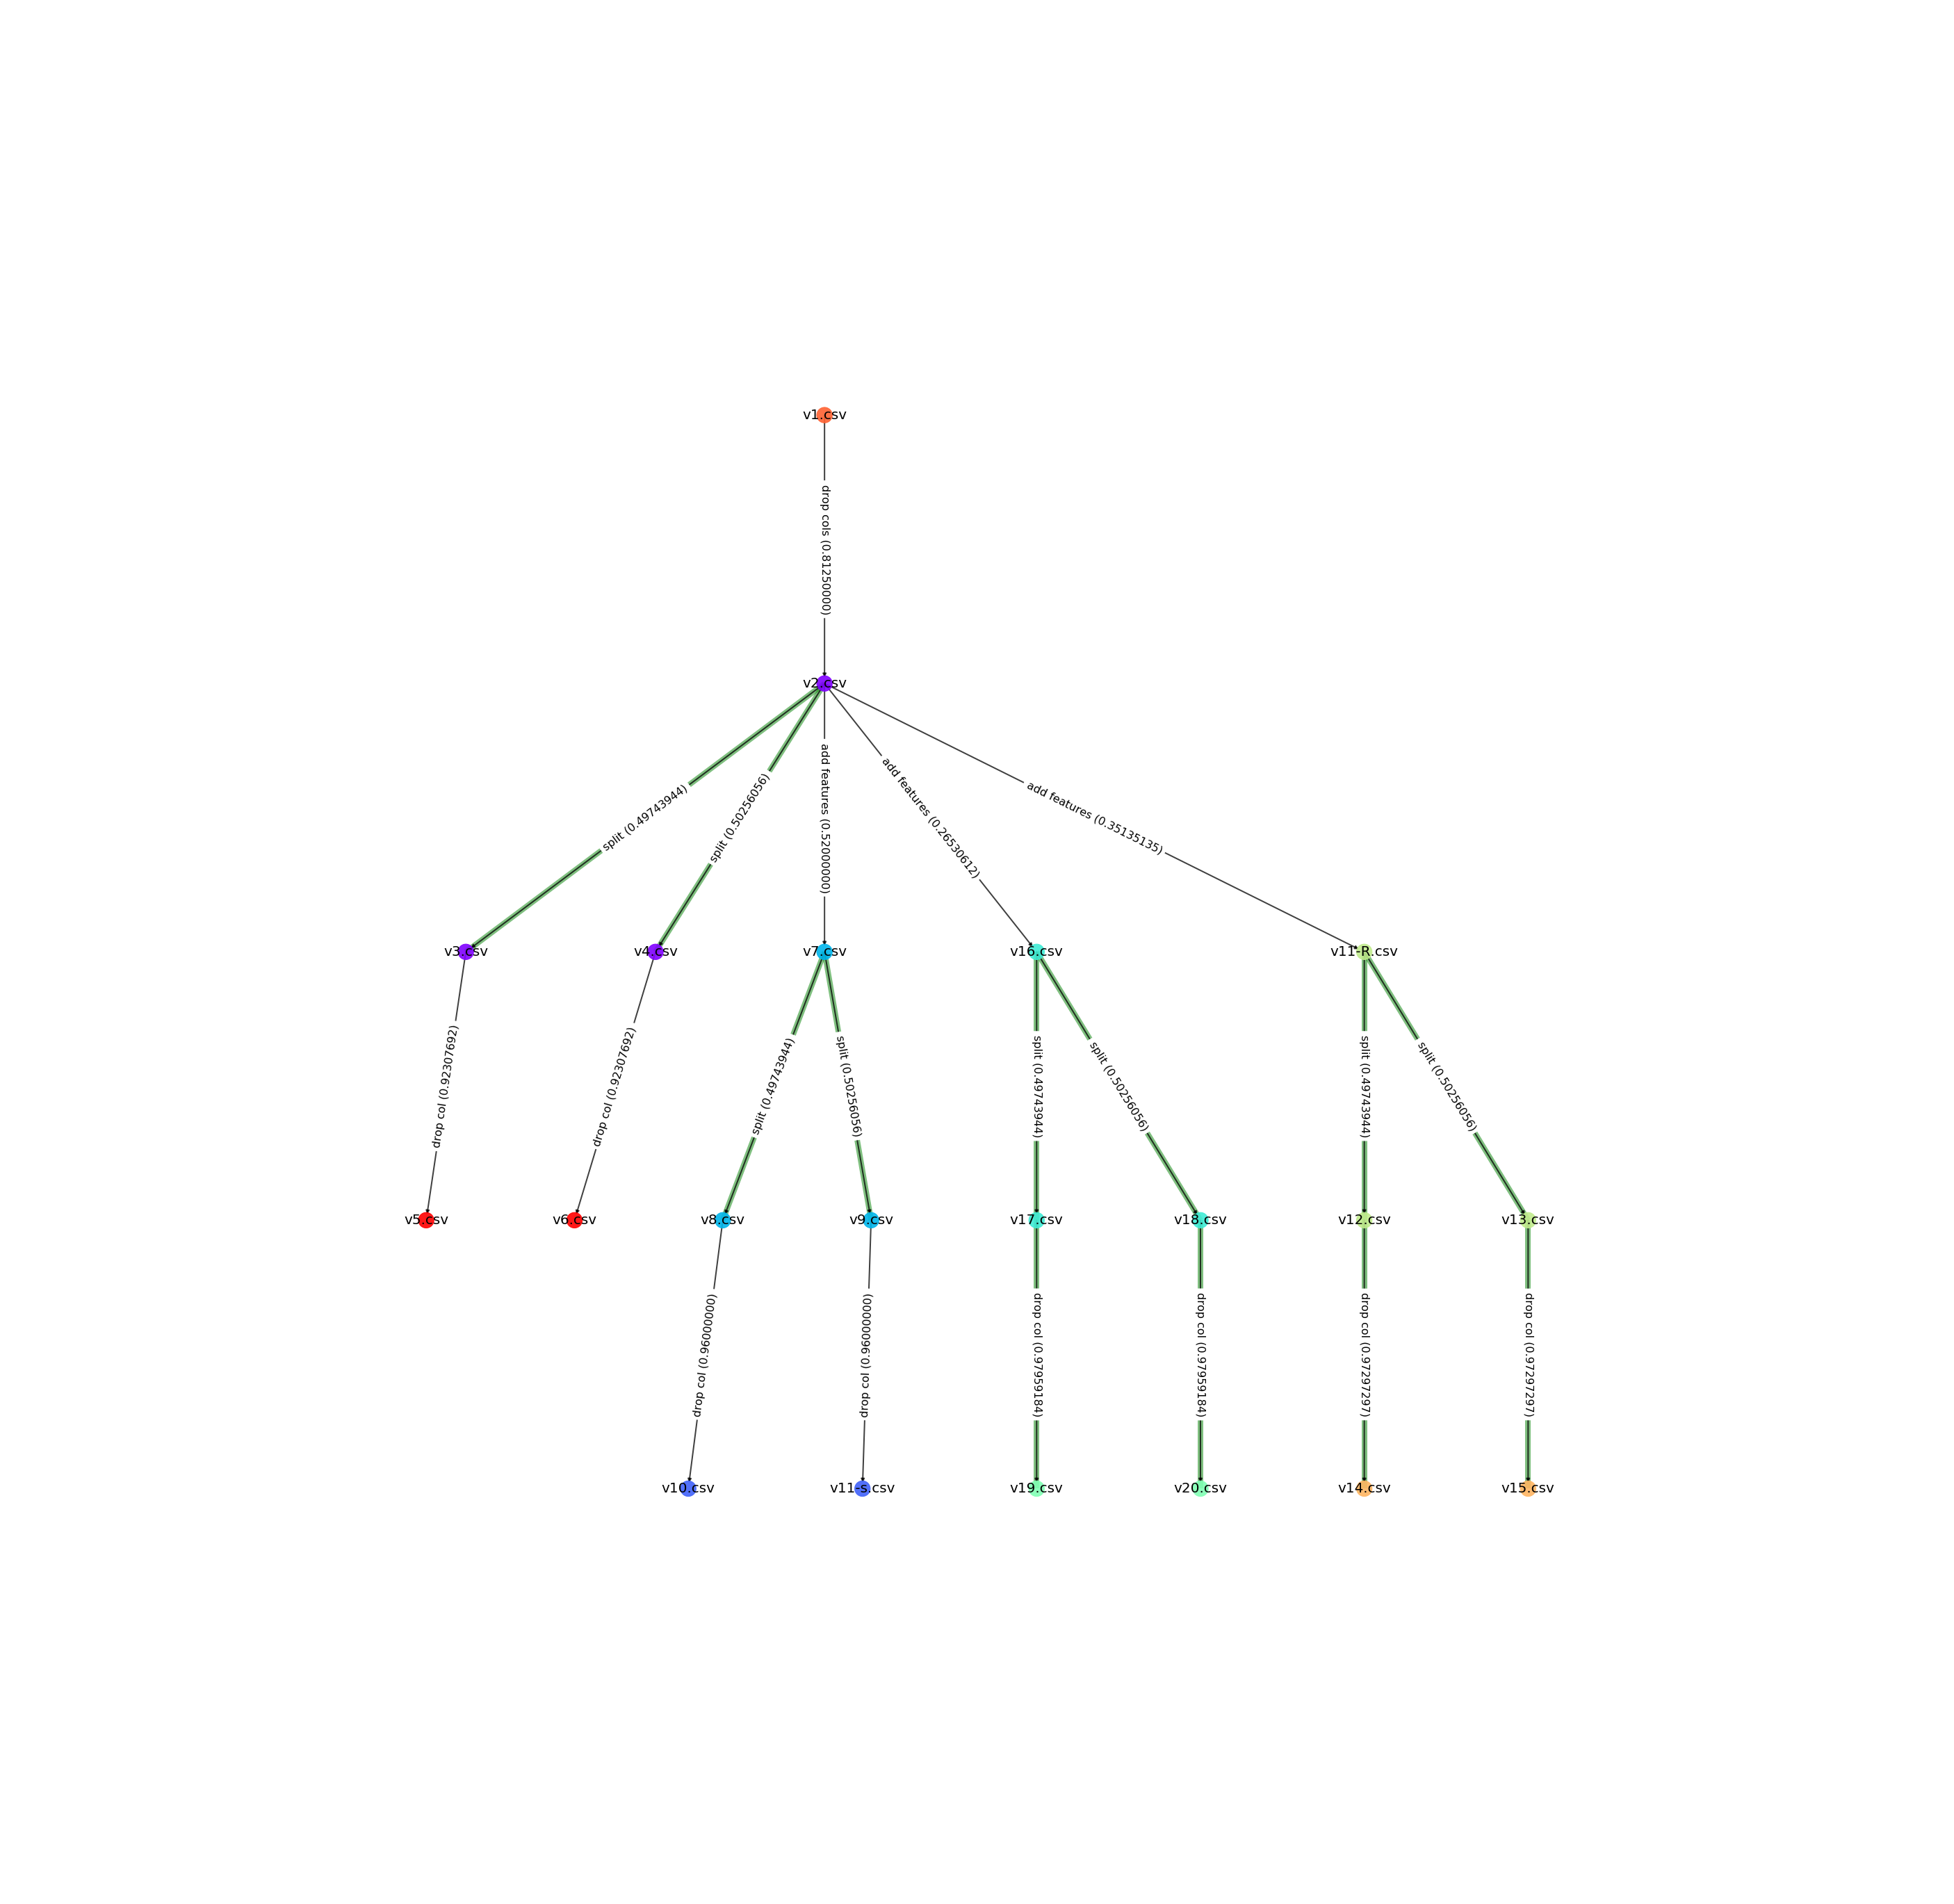

Adding edge v9.csv v11-s.csv 0.96
Components: [{'v4.csv', 'v2.csv', 'v3.csv'}, {'v7.csv', 'v9.csv', 'v11-s.csv', 'v8.csv'}, {'v16.csv', 'v18.csv', 'v19.csv', 'v17.csv', 'v20.csv'}, {'v13.csv', 'v14.csv', 'v12.csv', 'v15.csv', 'v11-R.csv'}, {'v10.csv'}, {'v1.csv'}, {'v5.csv'}, {'v6.csv'}]
None

v1.csv


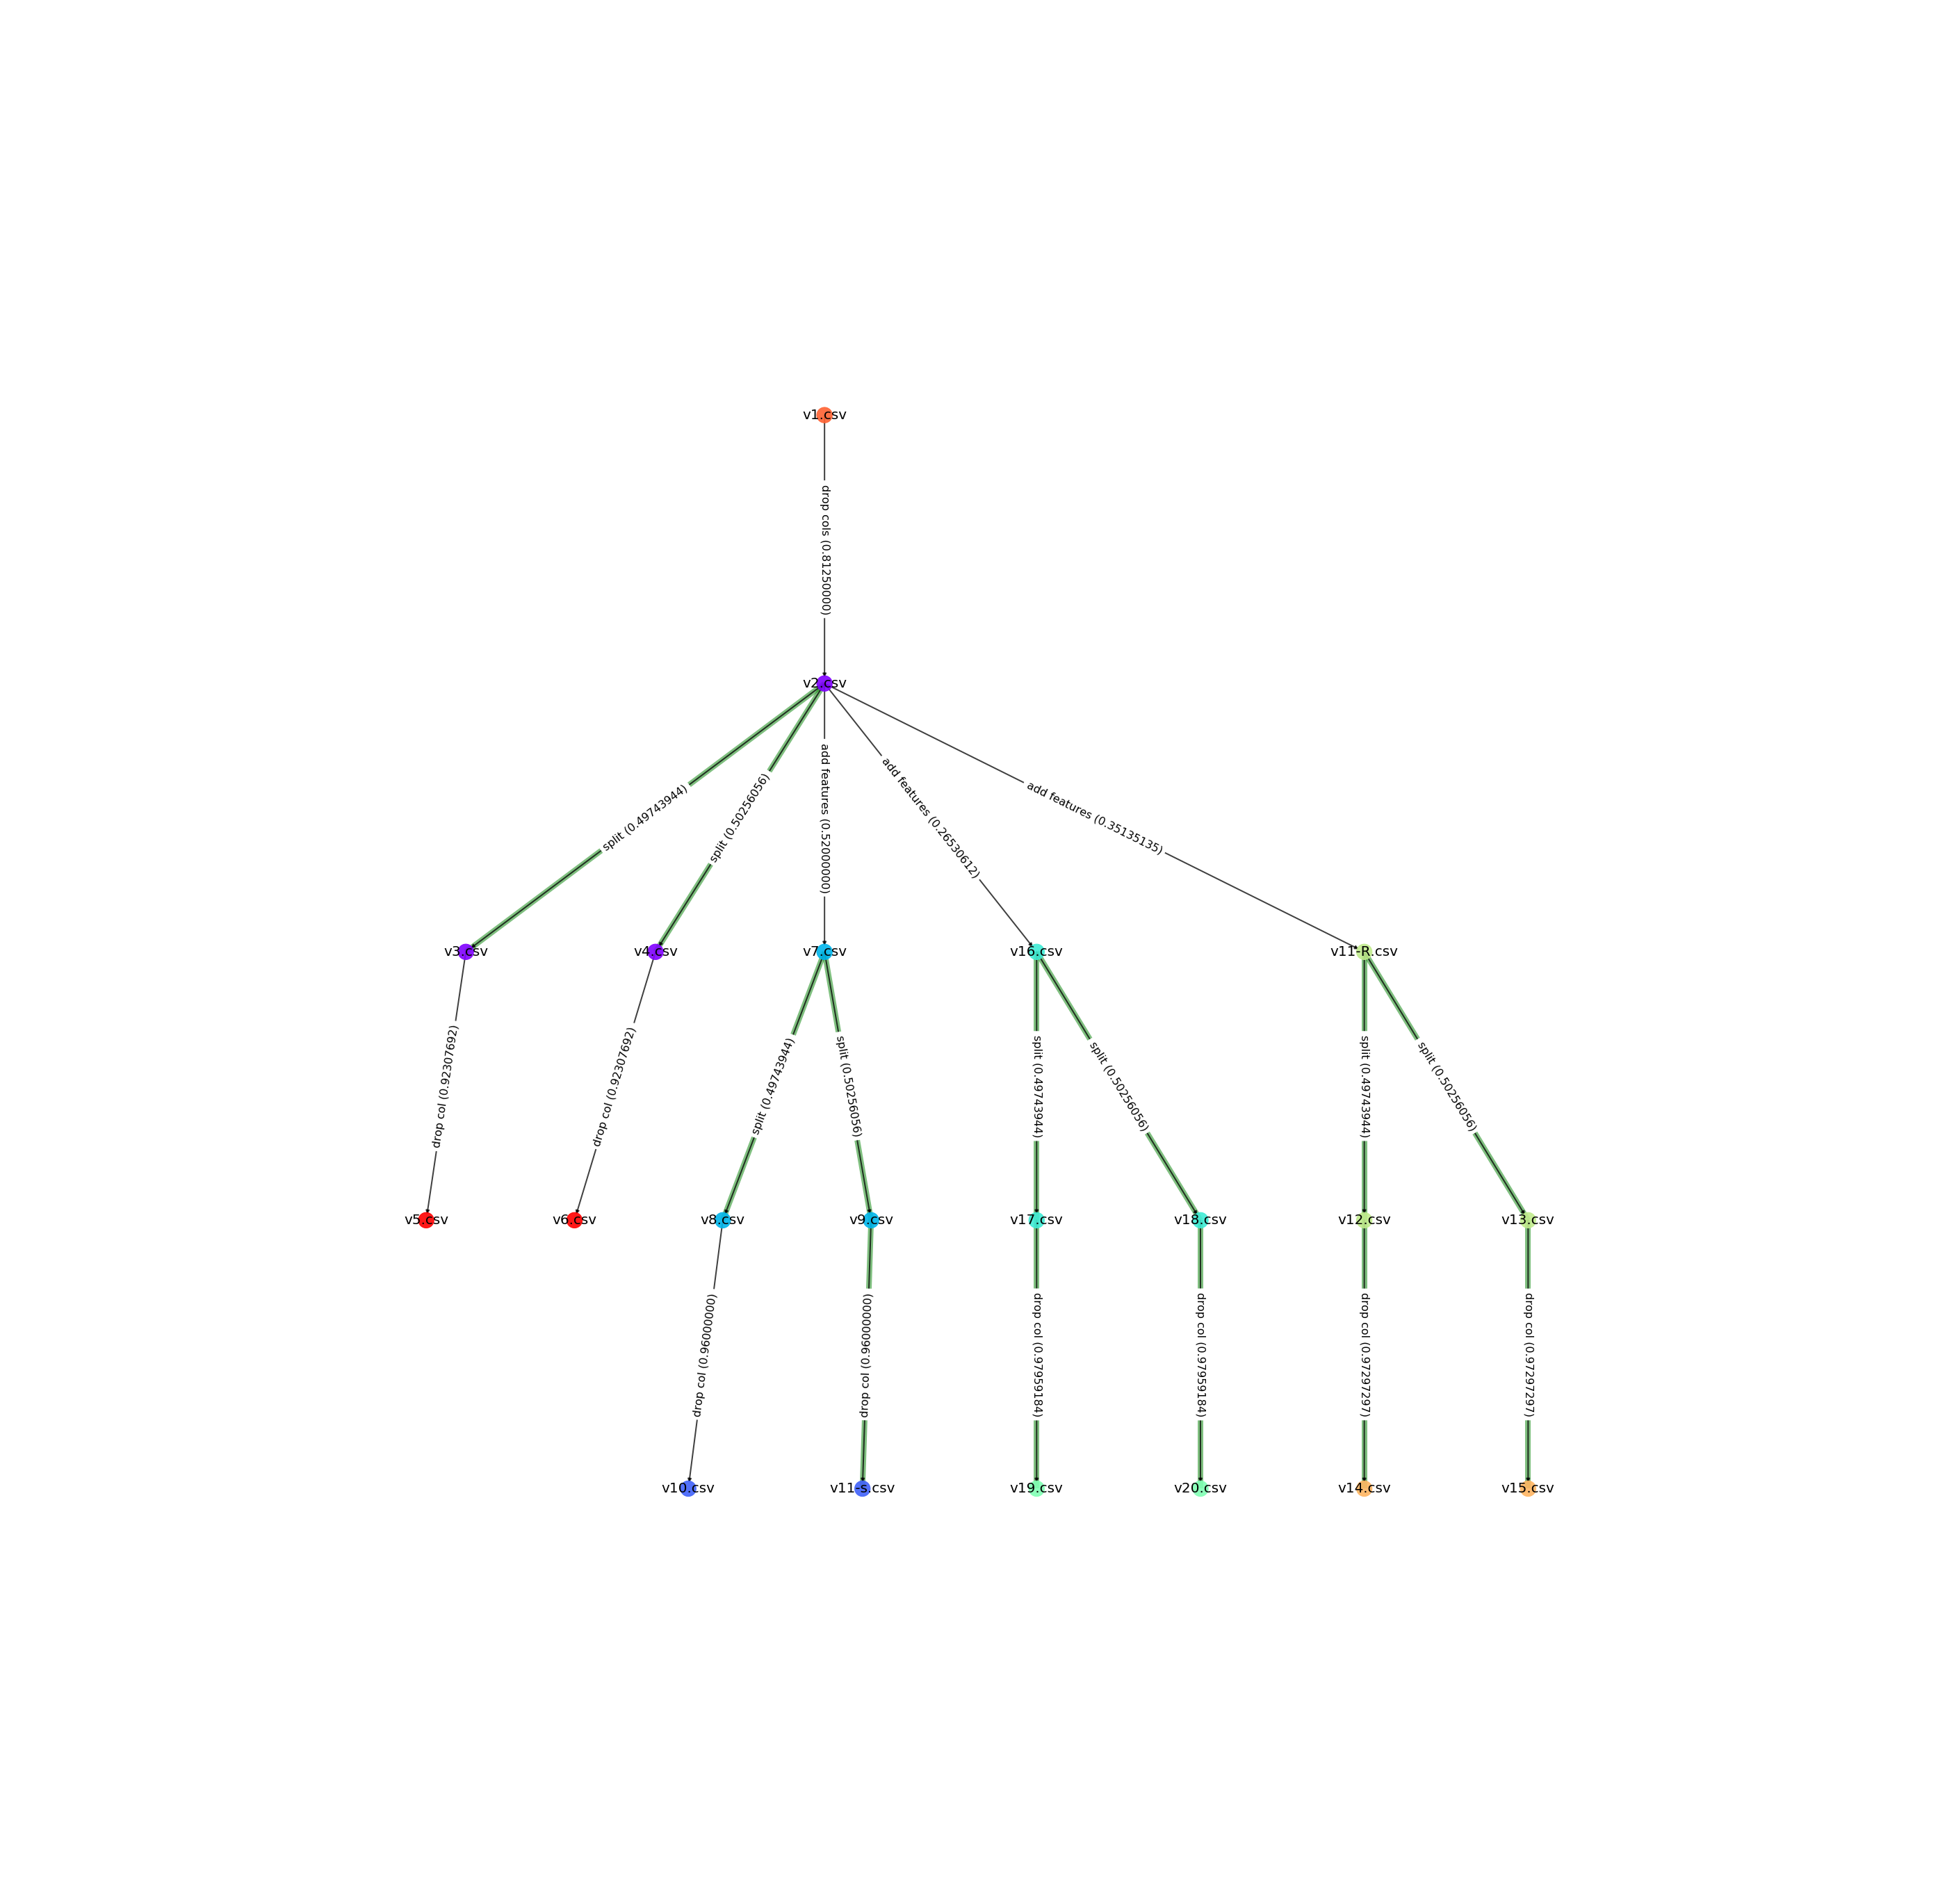

Adding edge v8.csv v10.csv 0.96
Components: [{'v4.csv', 'v2.csv', 'v3.csv'}, {'v9.csv', 'v10.csv', 'v11-s.csv', 'v8.csv', 'v7.csv'}, {'v16.csv', 'v18.csv', 'v19.csv', 'v17.csv', 'v20.csv'}, {'v13.csv', 'v14.csv', 'v12.csv', 'v15.csv', 'v11-R.csv'}, {'v1.csv'}, {'v5.csv'}, {'v6.csv'}]
None

v1.csv


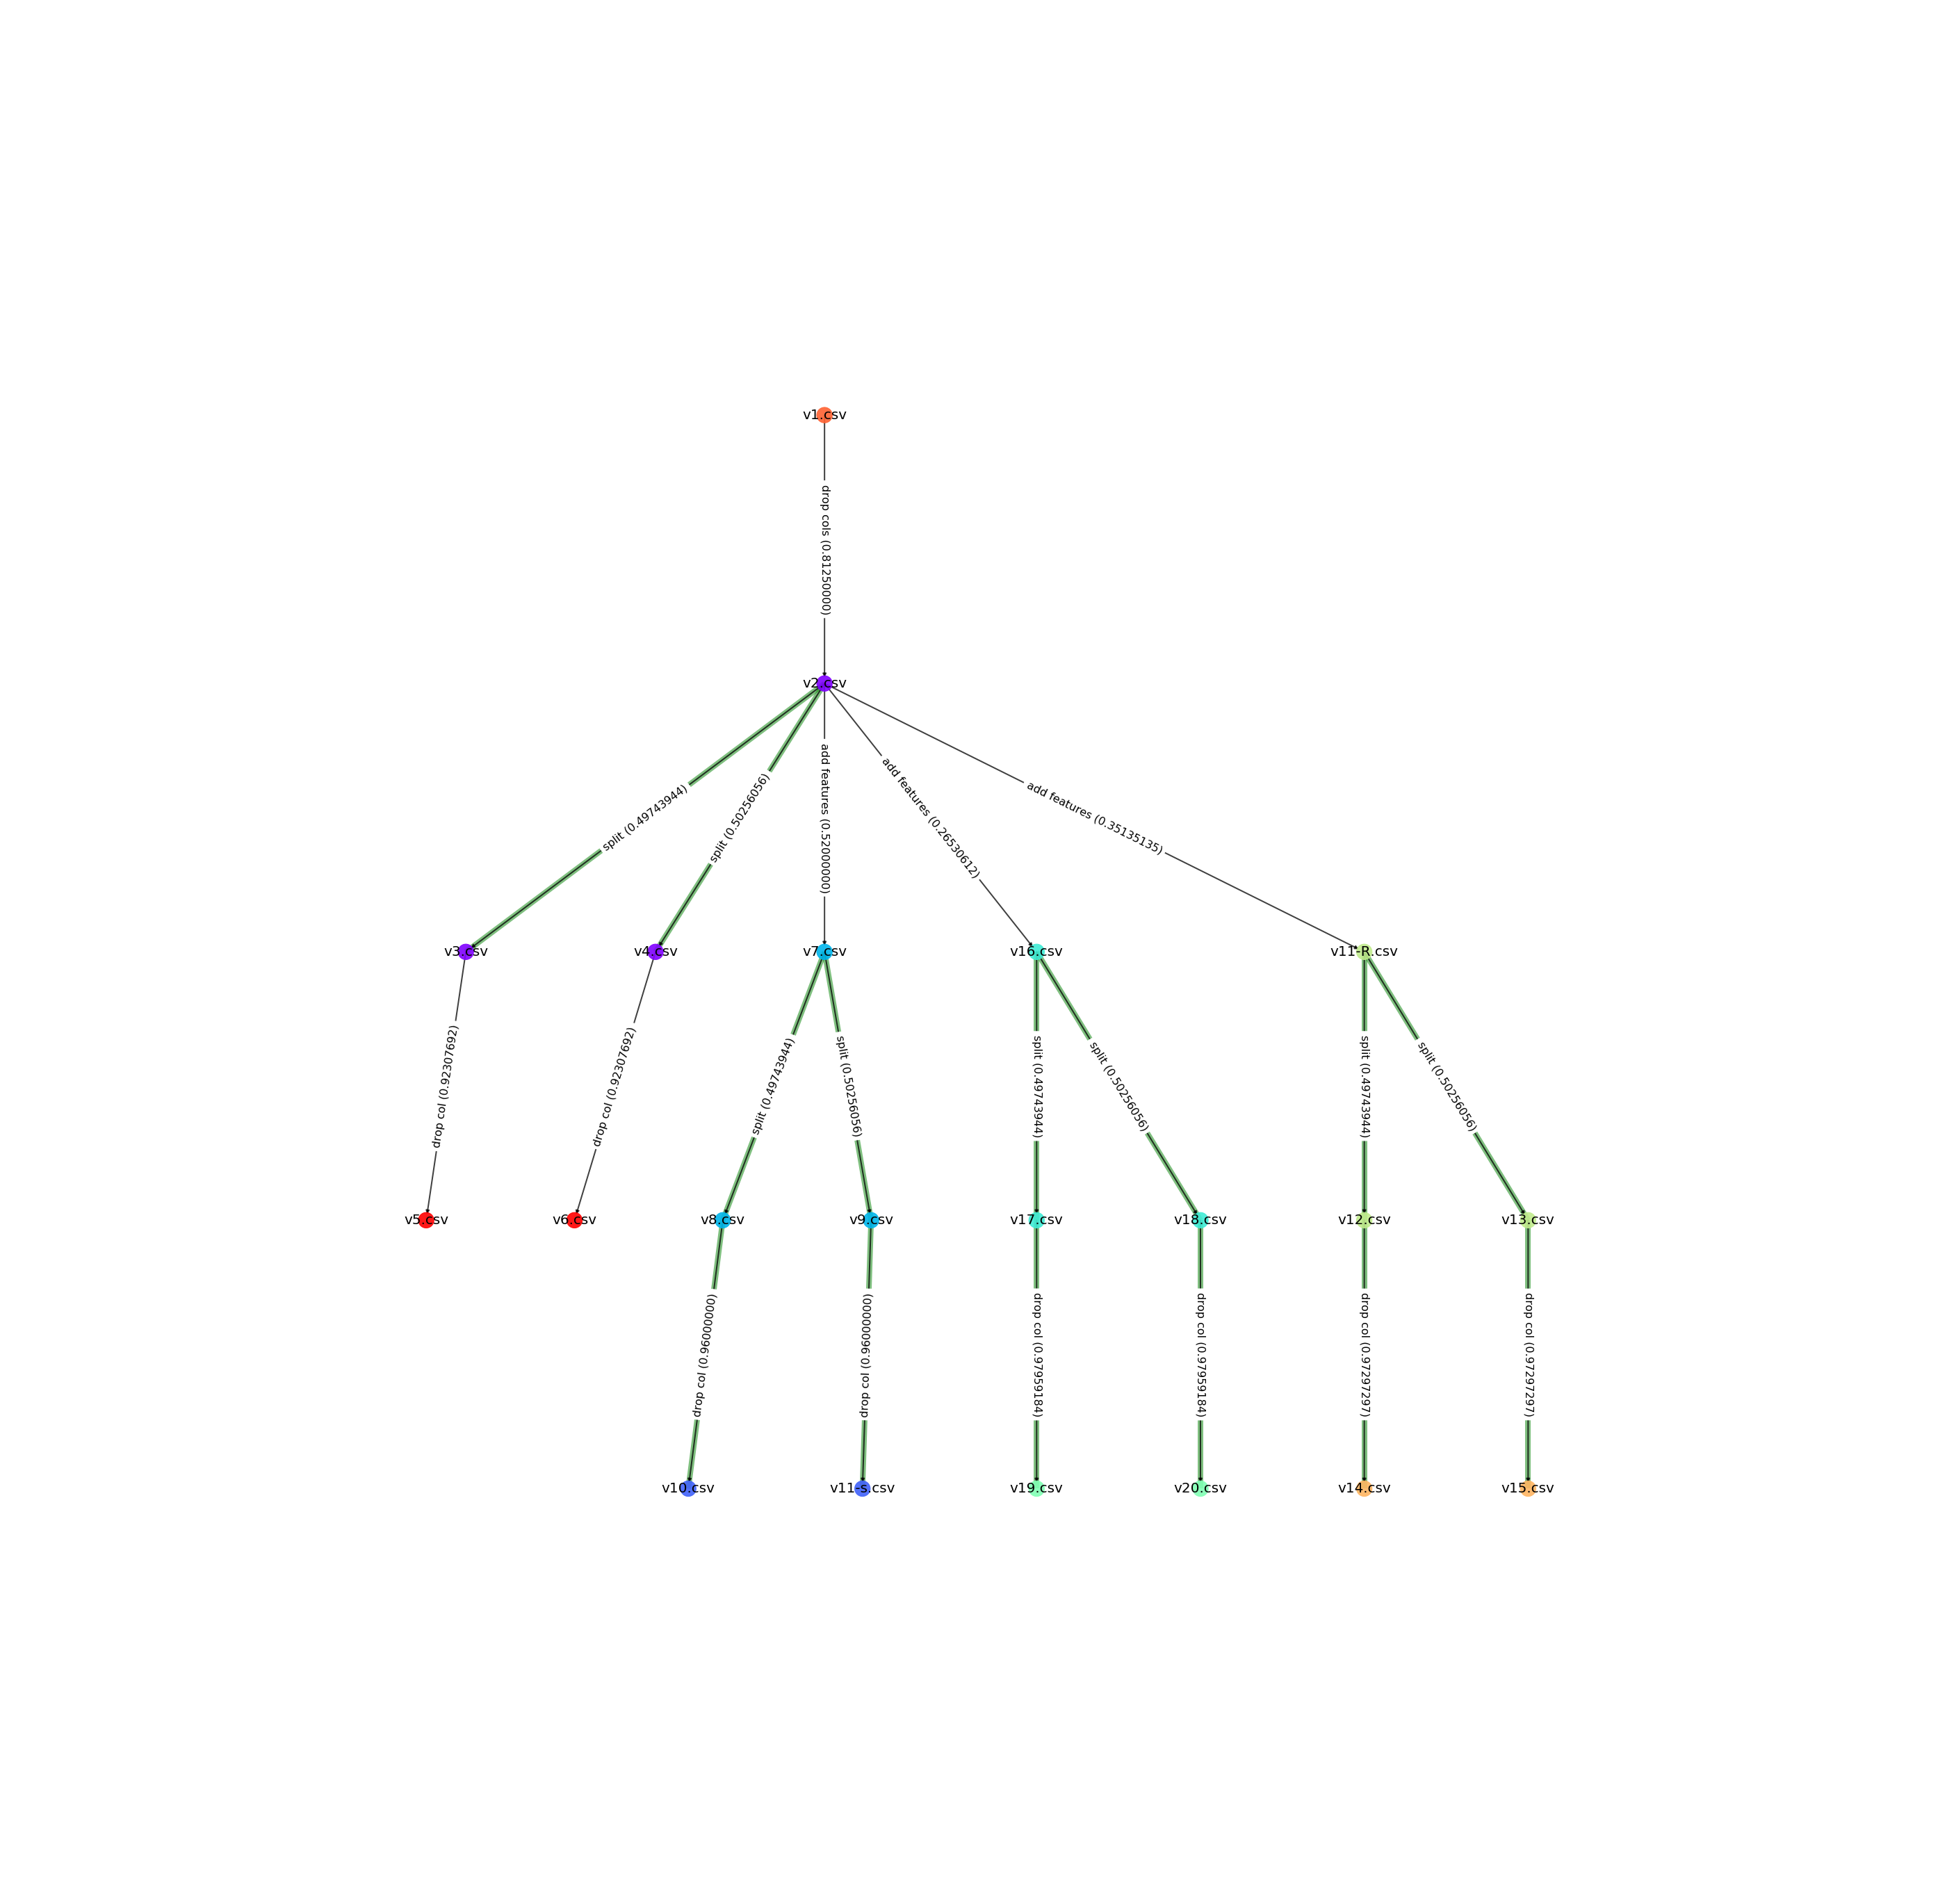

Adding edge v4.csv v6.csv 0.9230769230769231
Components: [{'v4.csv', 'v6.csv', 'v2.csv', 'v3.csv'}, {'v9.csv', 'v10.csv', 'v11-s.csv', 'v8.csv', 'v7.csv'}, {'v16.csv', 'v18.csv', 'v19.csv', 'v17.csv', 'v20.csv'}, {'v13.csv', 'v14.csv', 'v12.csv', 'v15.csv', 'v11-R.csv'}, {'v1.csv'}, {'v5.csv'}]
None

v1.csv


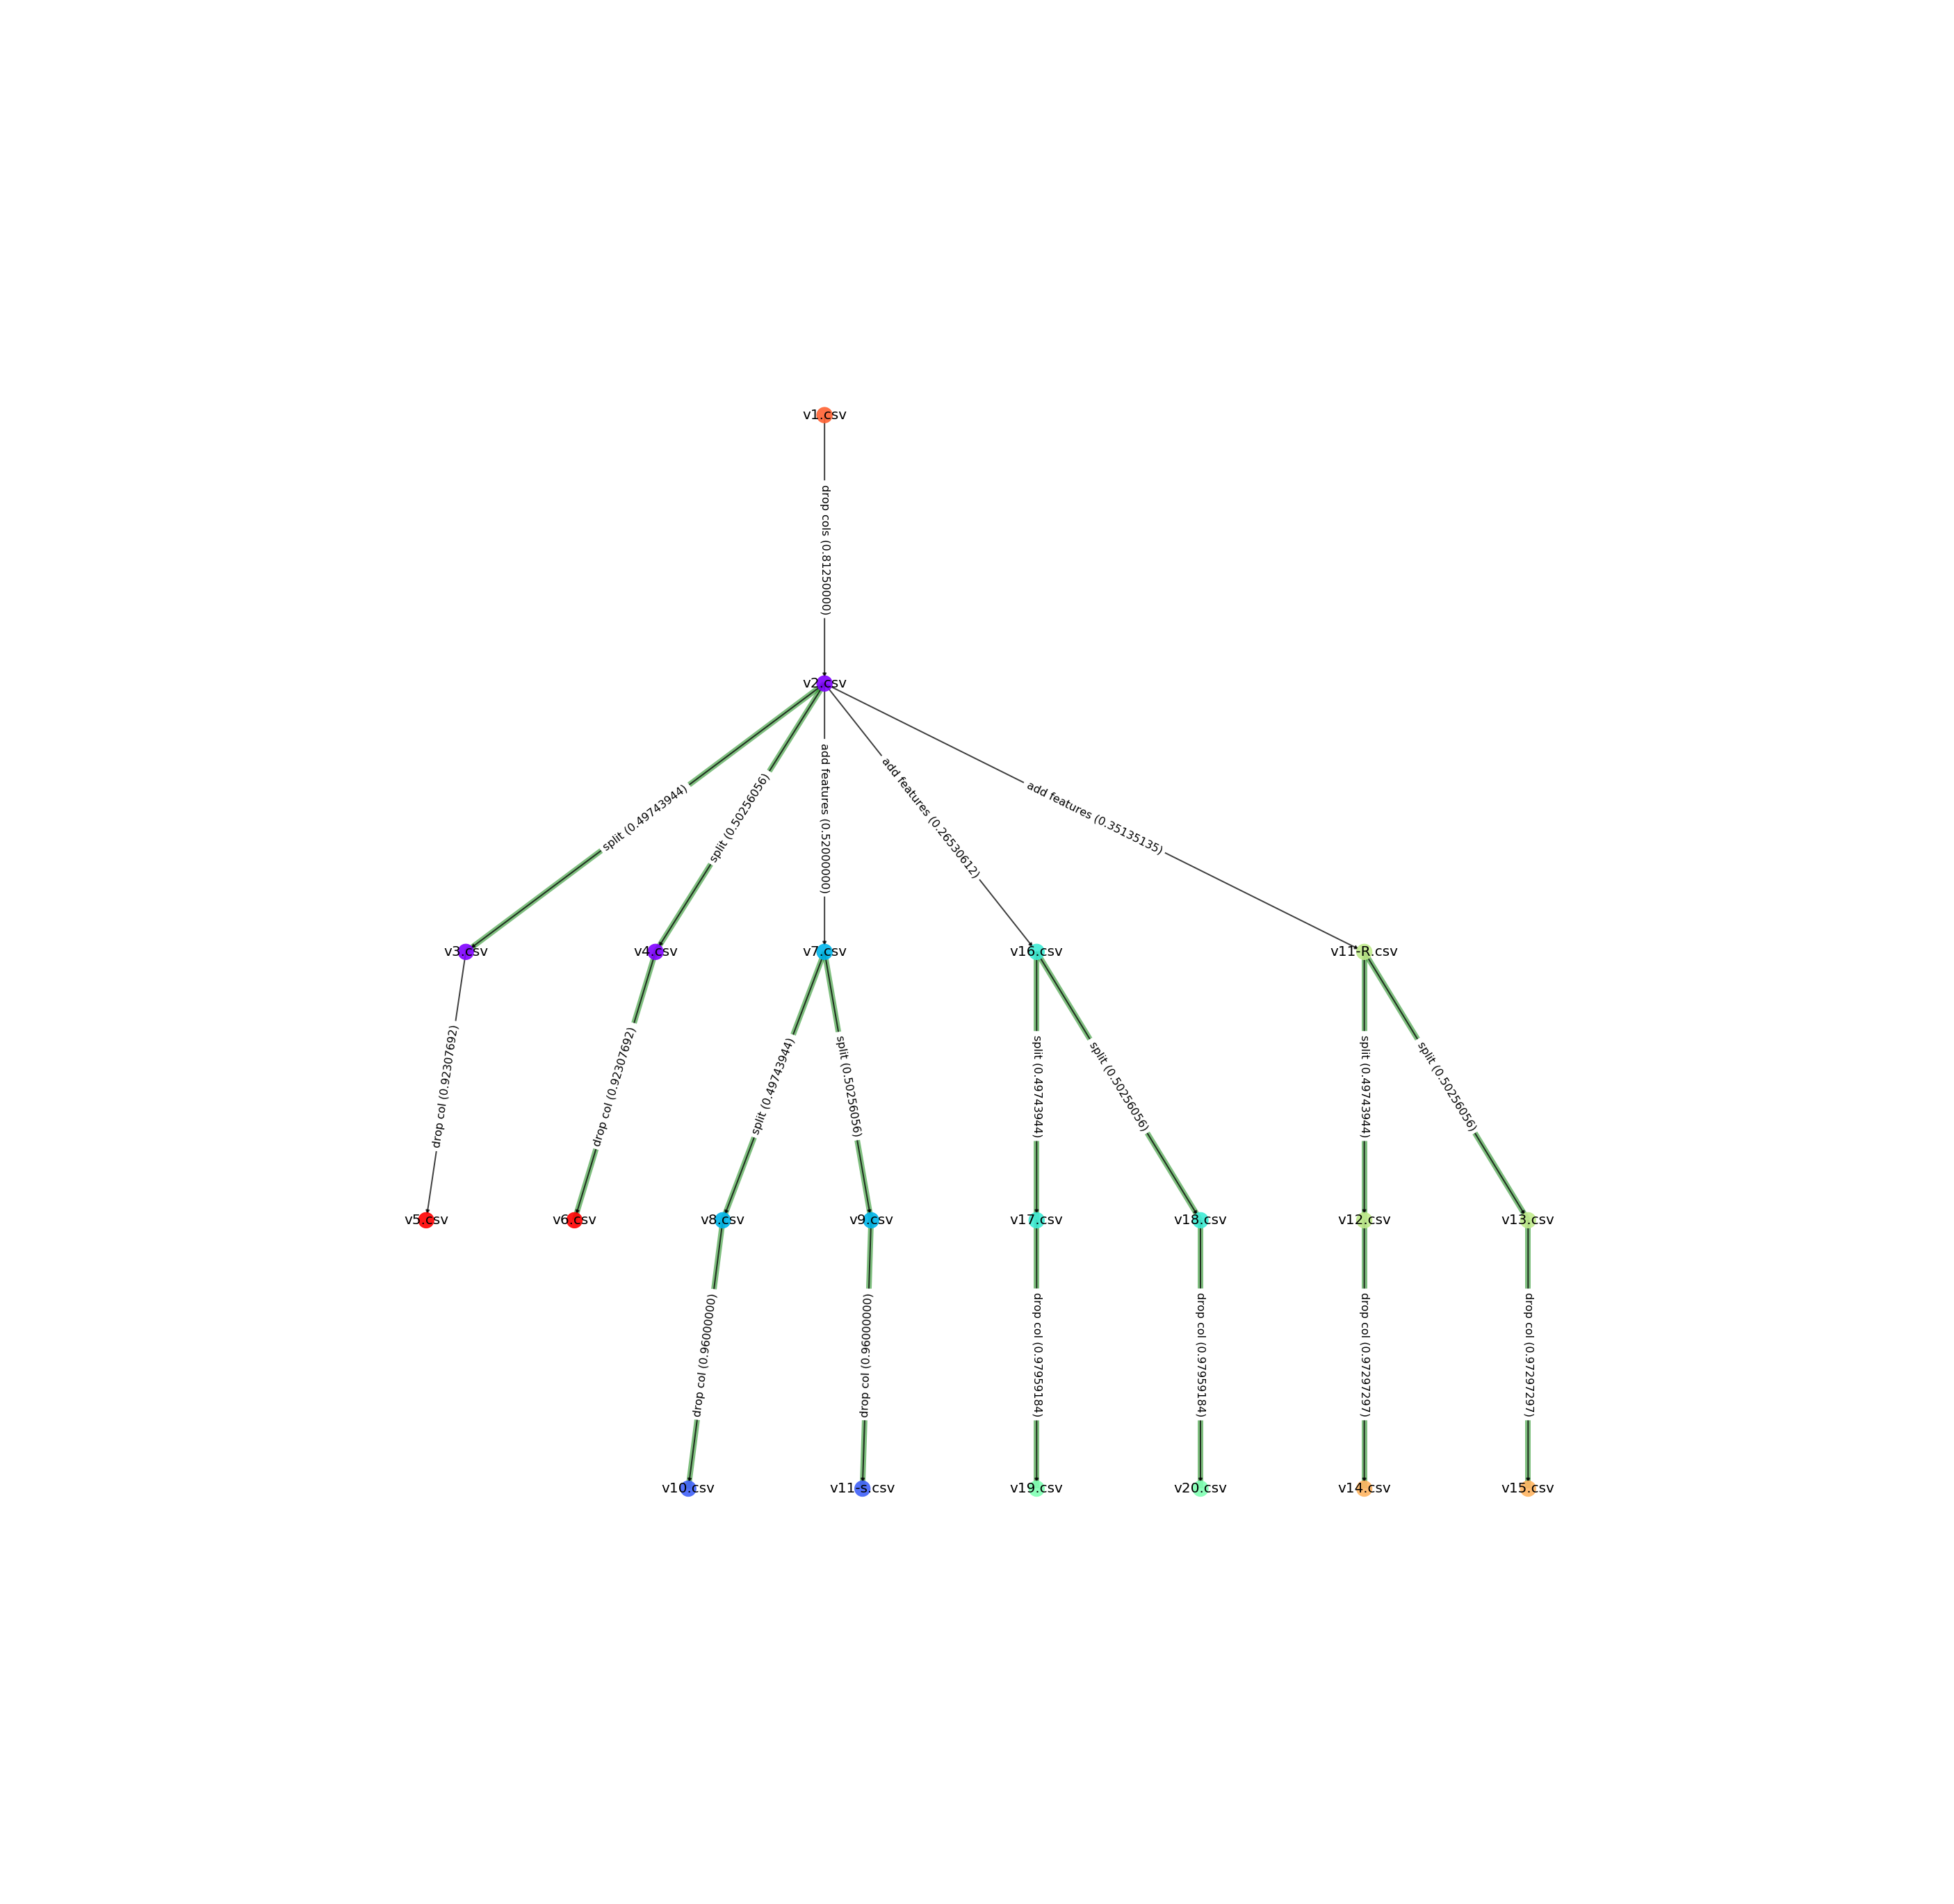

Adding edge v3.csv v5.csv 0.9230769230769231
Components: [{'v5.csv', 'v4.csv', 'v6.csv', 'v3.csv', 'v2.csv'}, {'v9.csv', 'v10.csv', 'v11-s.csv', 'v8.csv', 'v7.csv'}, {'v16.csv', 'v18.csv', 'v19.csv', 'v17.csv', 'v20.csv'}, {'v13.csv', 'v14.csv', 'v12.csv', 'v15.csv', 'v11-R.csv'}, {'v1.csv'}]
None

v1.csv


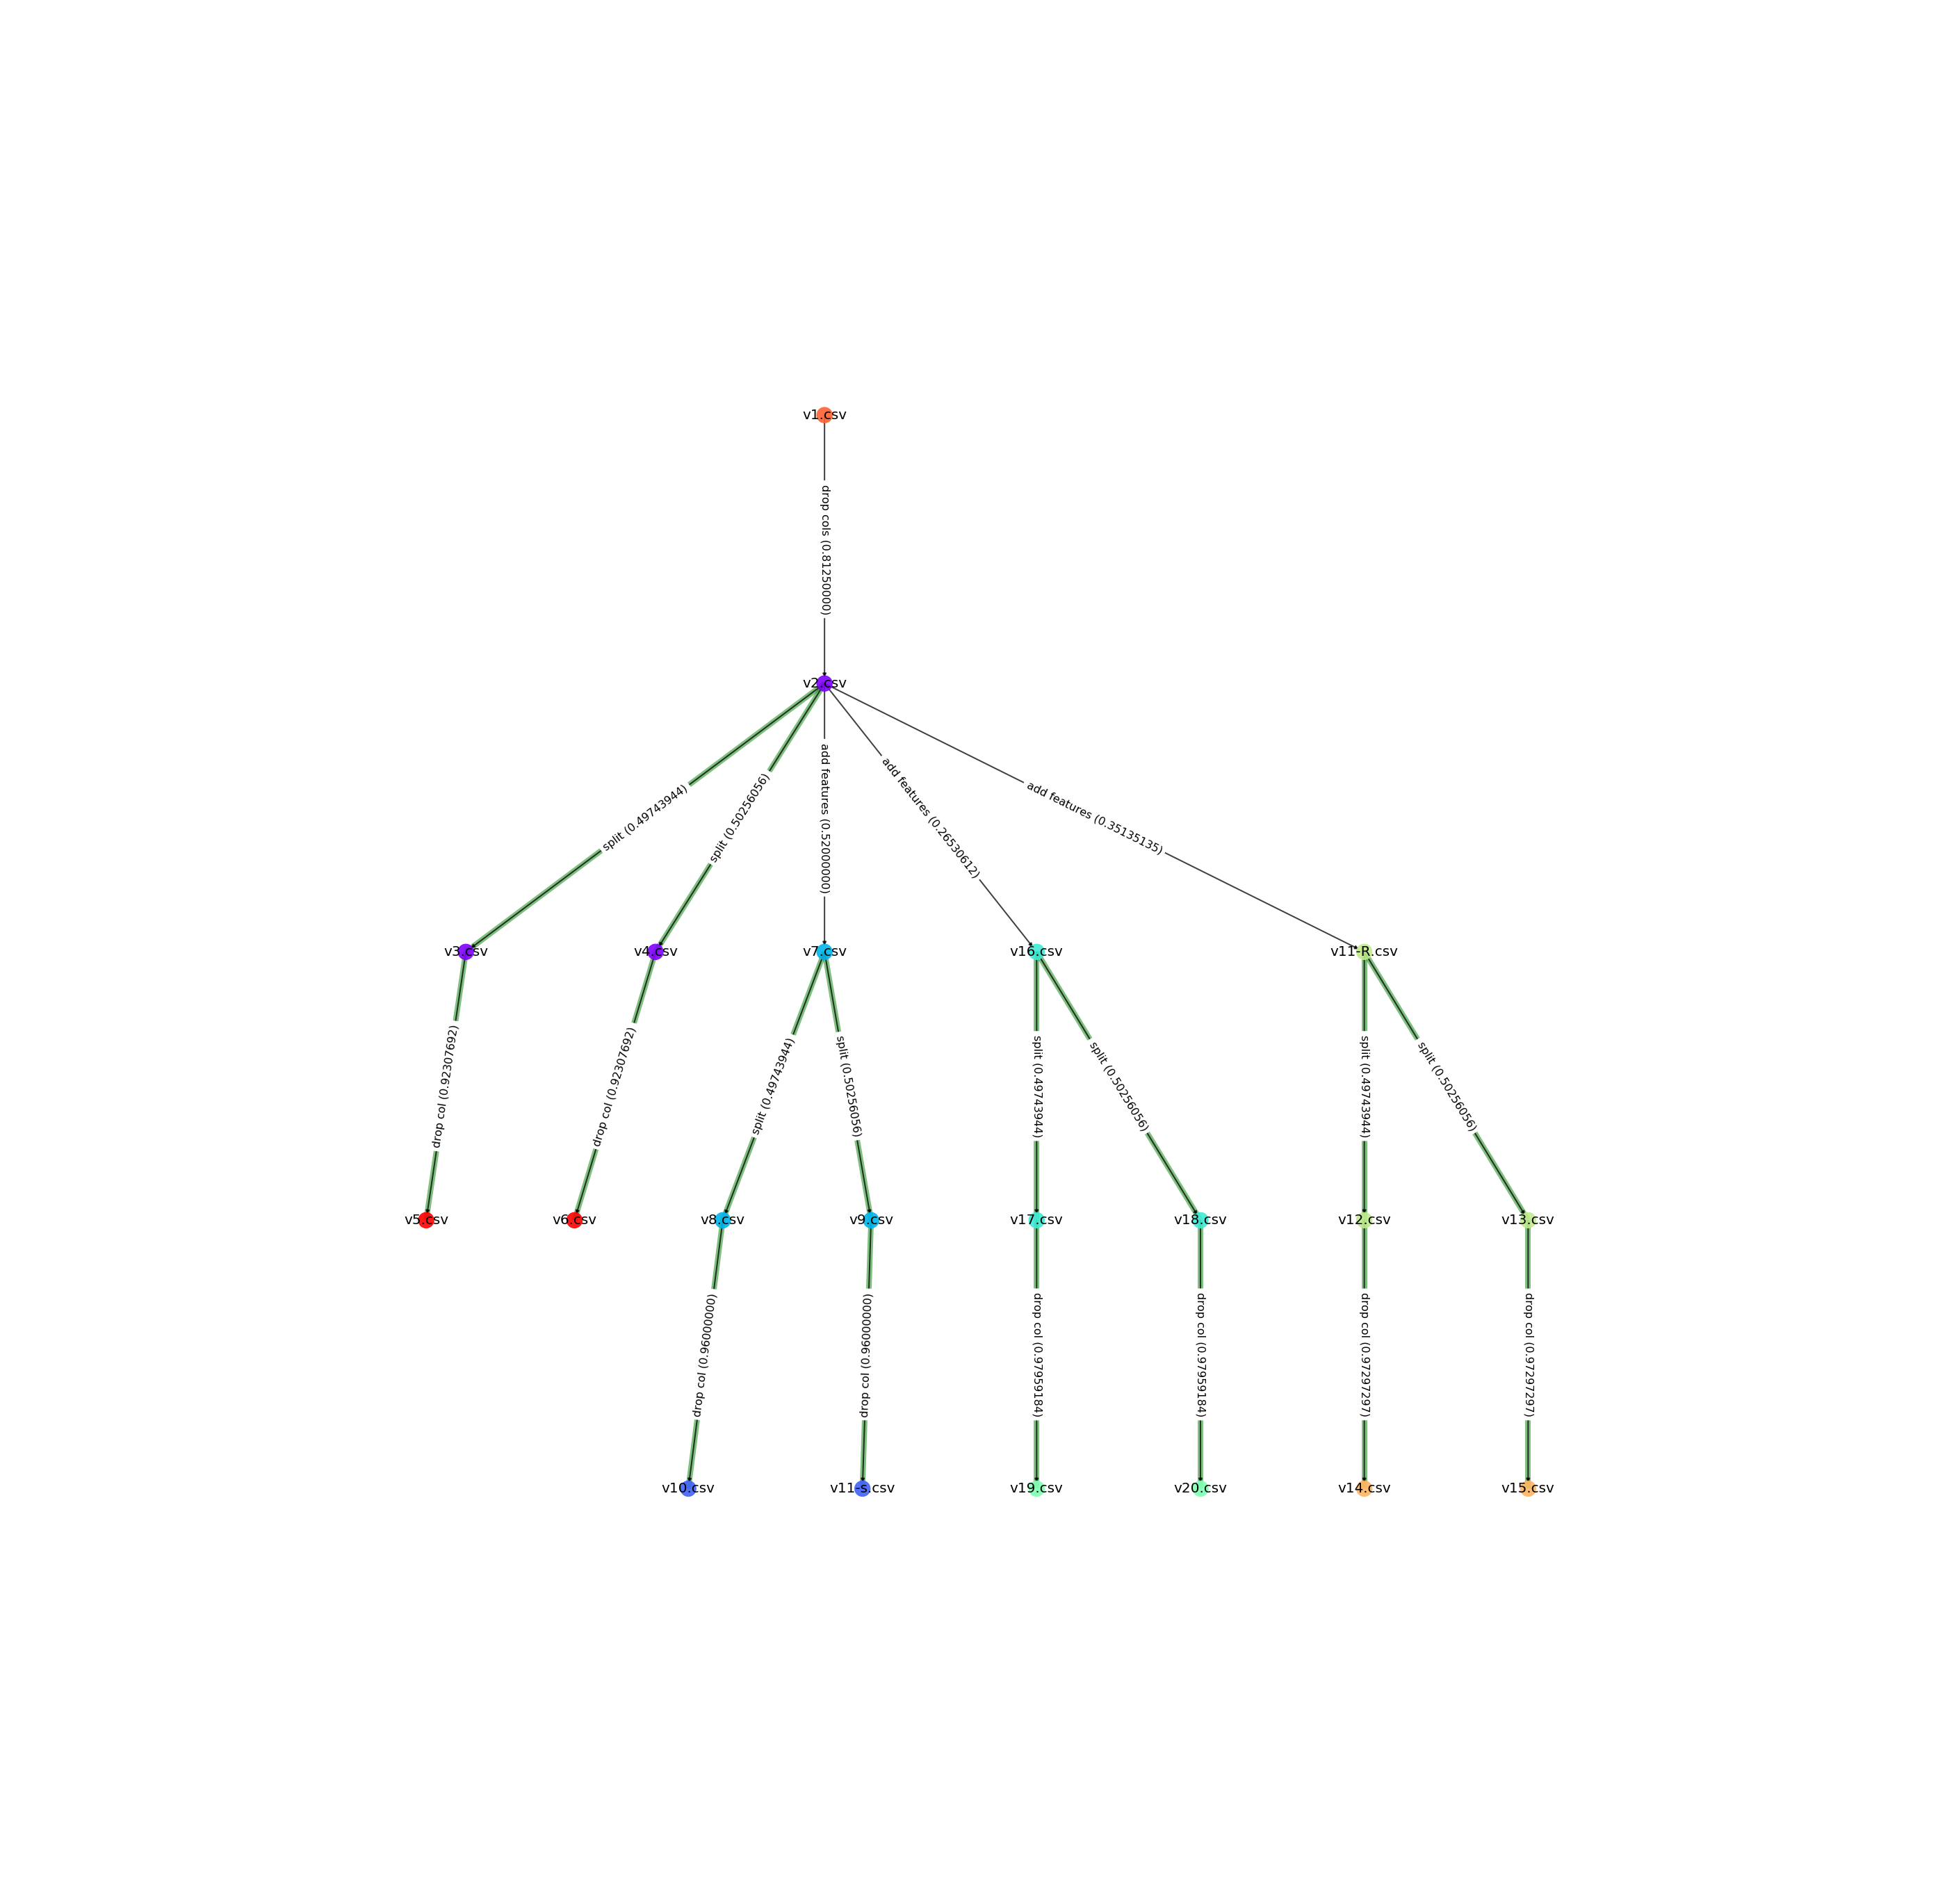

Adding edge v2.csv v1.csv 0.8125
Components: [{'v5.csv', 'v4.csv', 'v6.csv', 'v1.csv', 'v3.csv', 'v2.csv'}, {'v9.csv', 'v10.csv', 'v11-s.csv', 'v8.csv', 'v7.csv'}, {'v16.csv', 'v18.csv', 'v19.csv', 'v17.csv', 'v20.csv'}, {'v13.csv', 'v14.csv', 'v12.csv', 'v15.csv', 'v11-R.csv'}]
None

v5.csv


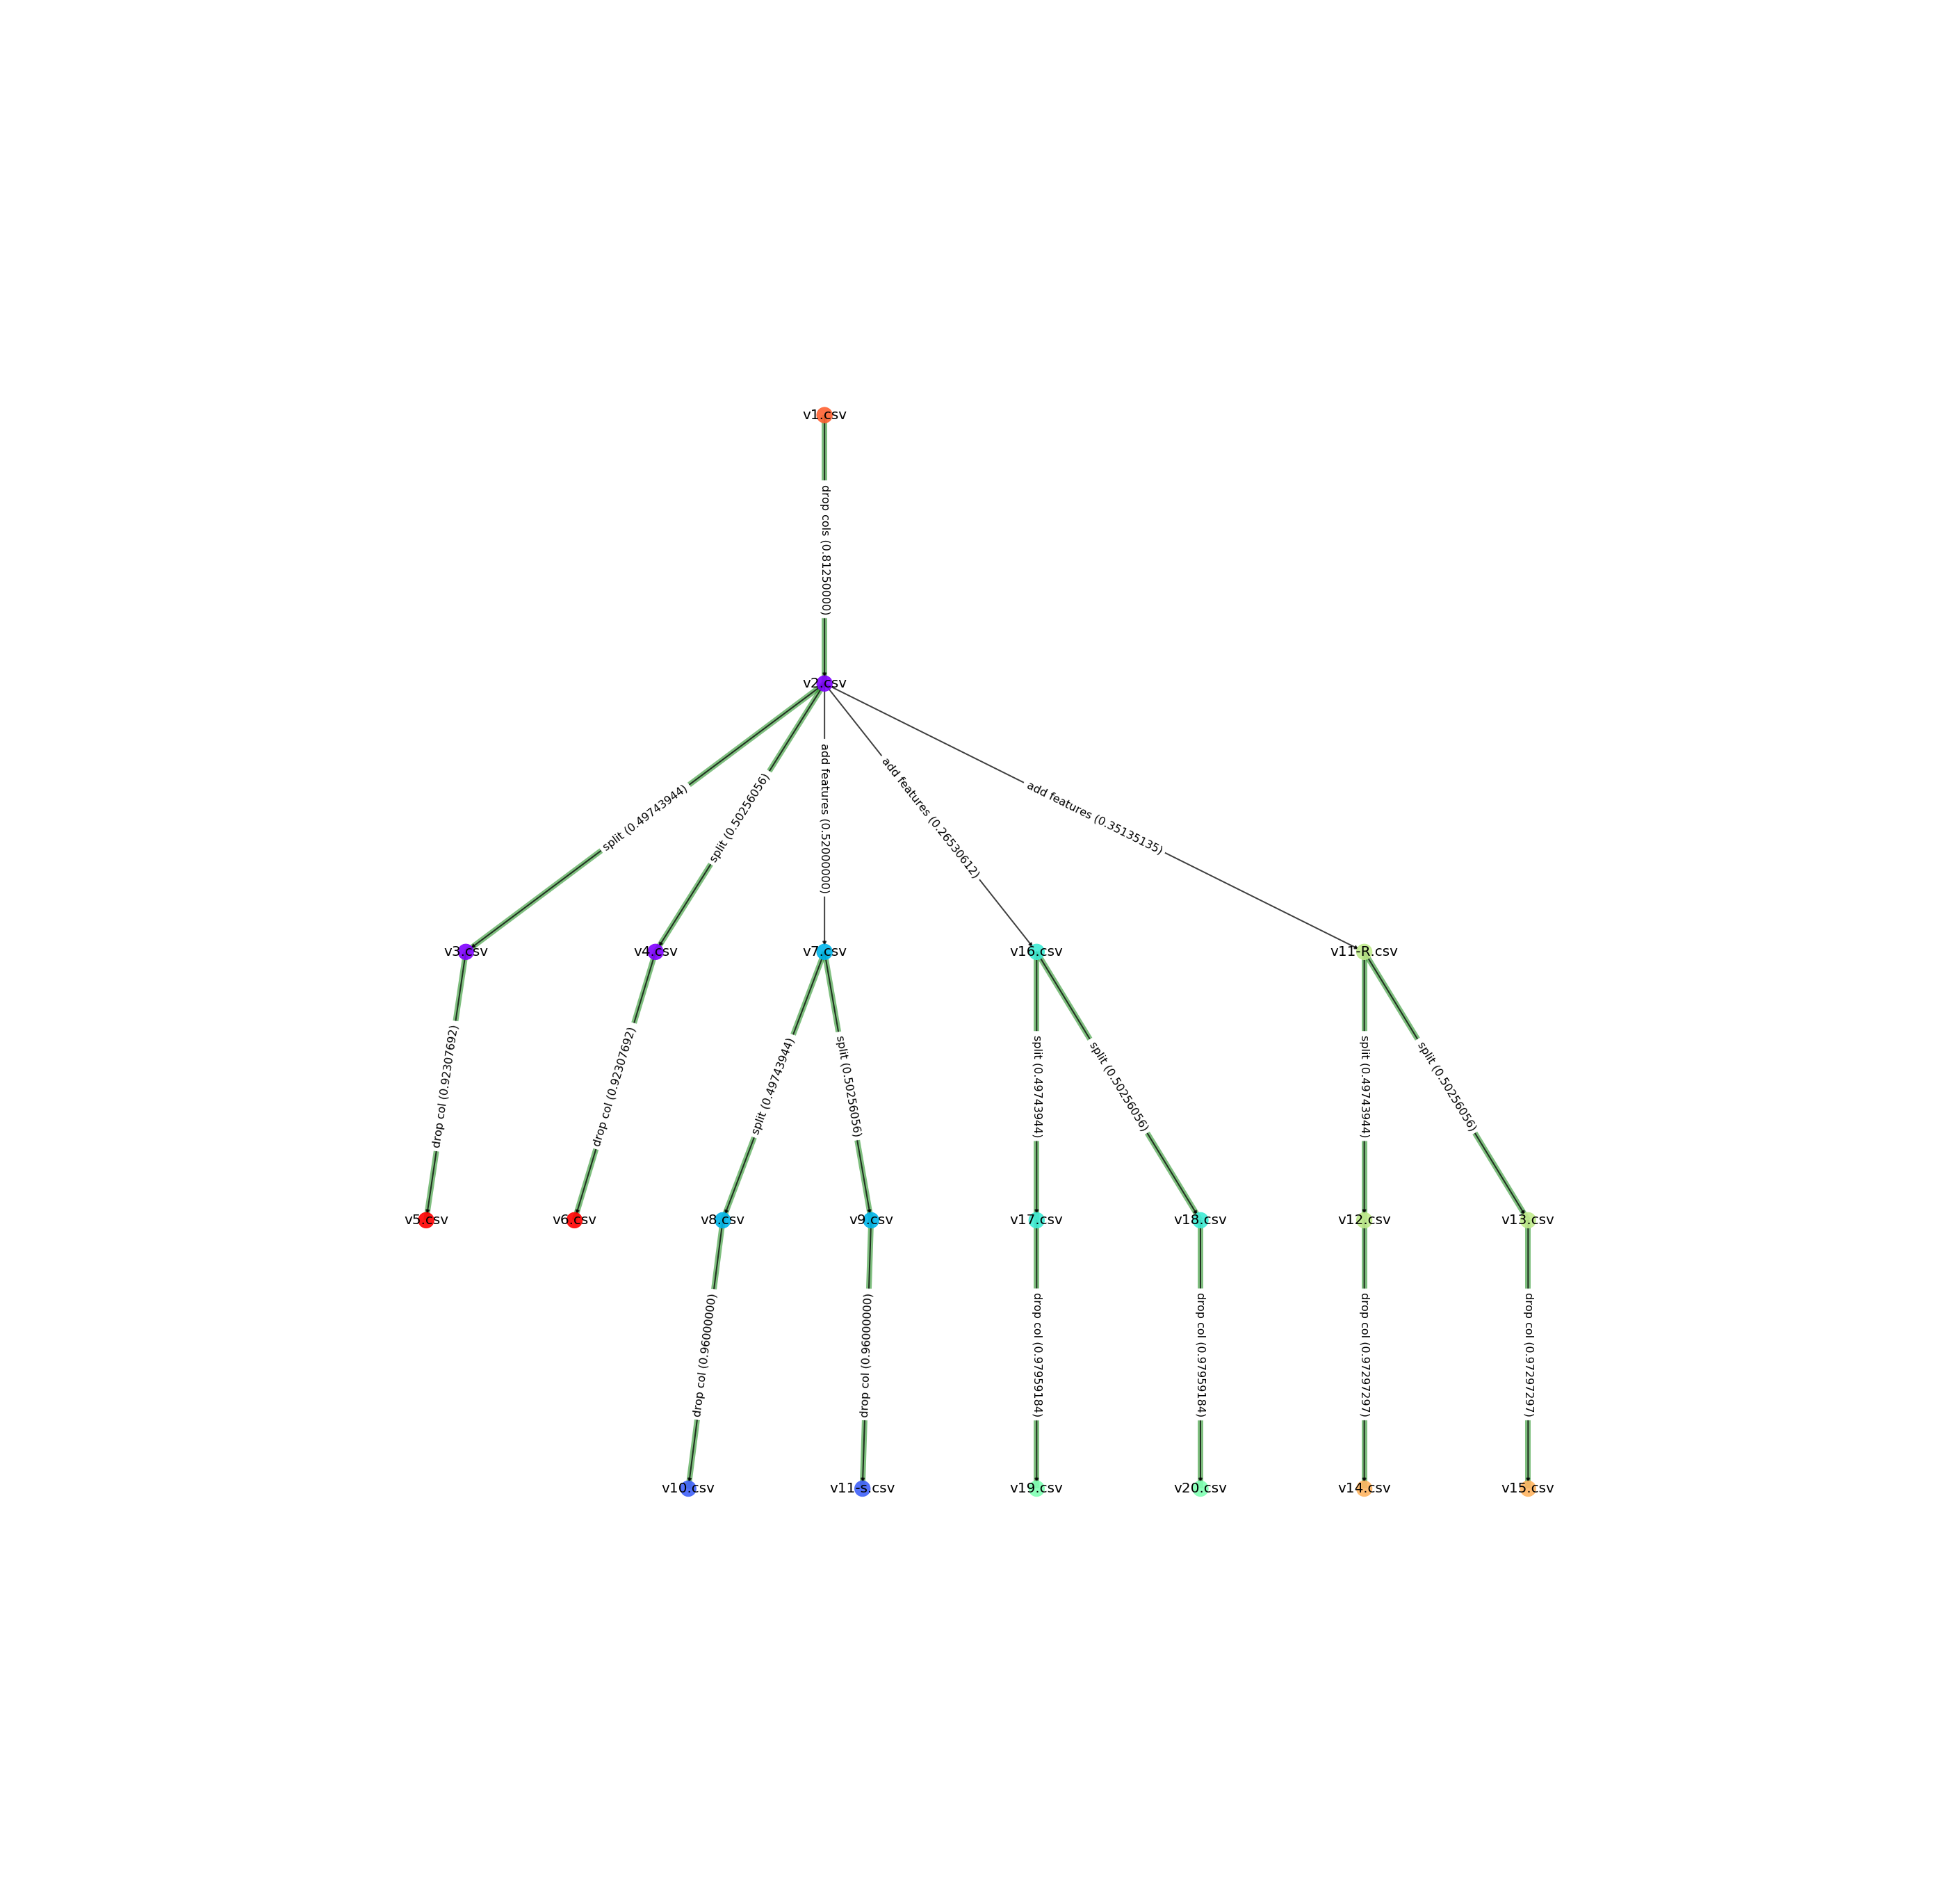

Adding edge v16.csv v11-R.csv 0.7551020408163265
Components: [{'v5.csv', 'v4.csv', 'v6.csv', 'v1.csv', 'v3.csv', 'v2.csv'}, {'v9.csv', 'v10.csv', 'v11-s.csv', 'v8.csv', 'v7.csv'}, {'v16.csv', 'v18.csv', 'v13.csv', 'v14.csv', 'v12.csv', 'v19.csv', 'v15.csv', 'v11-R.csv', 'v17.csv', 'v20.csv'}]
None

v5.csv


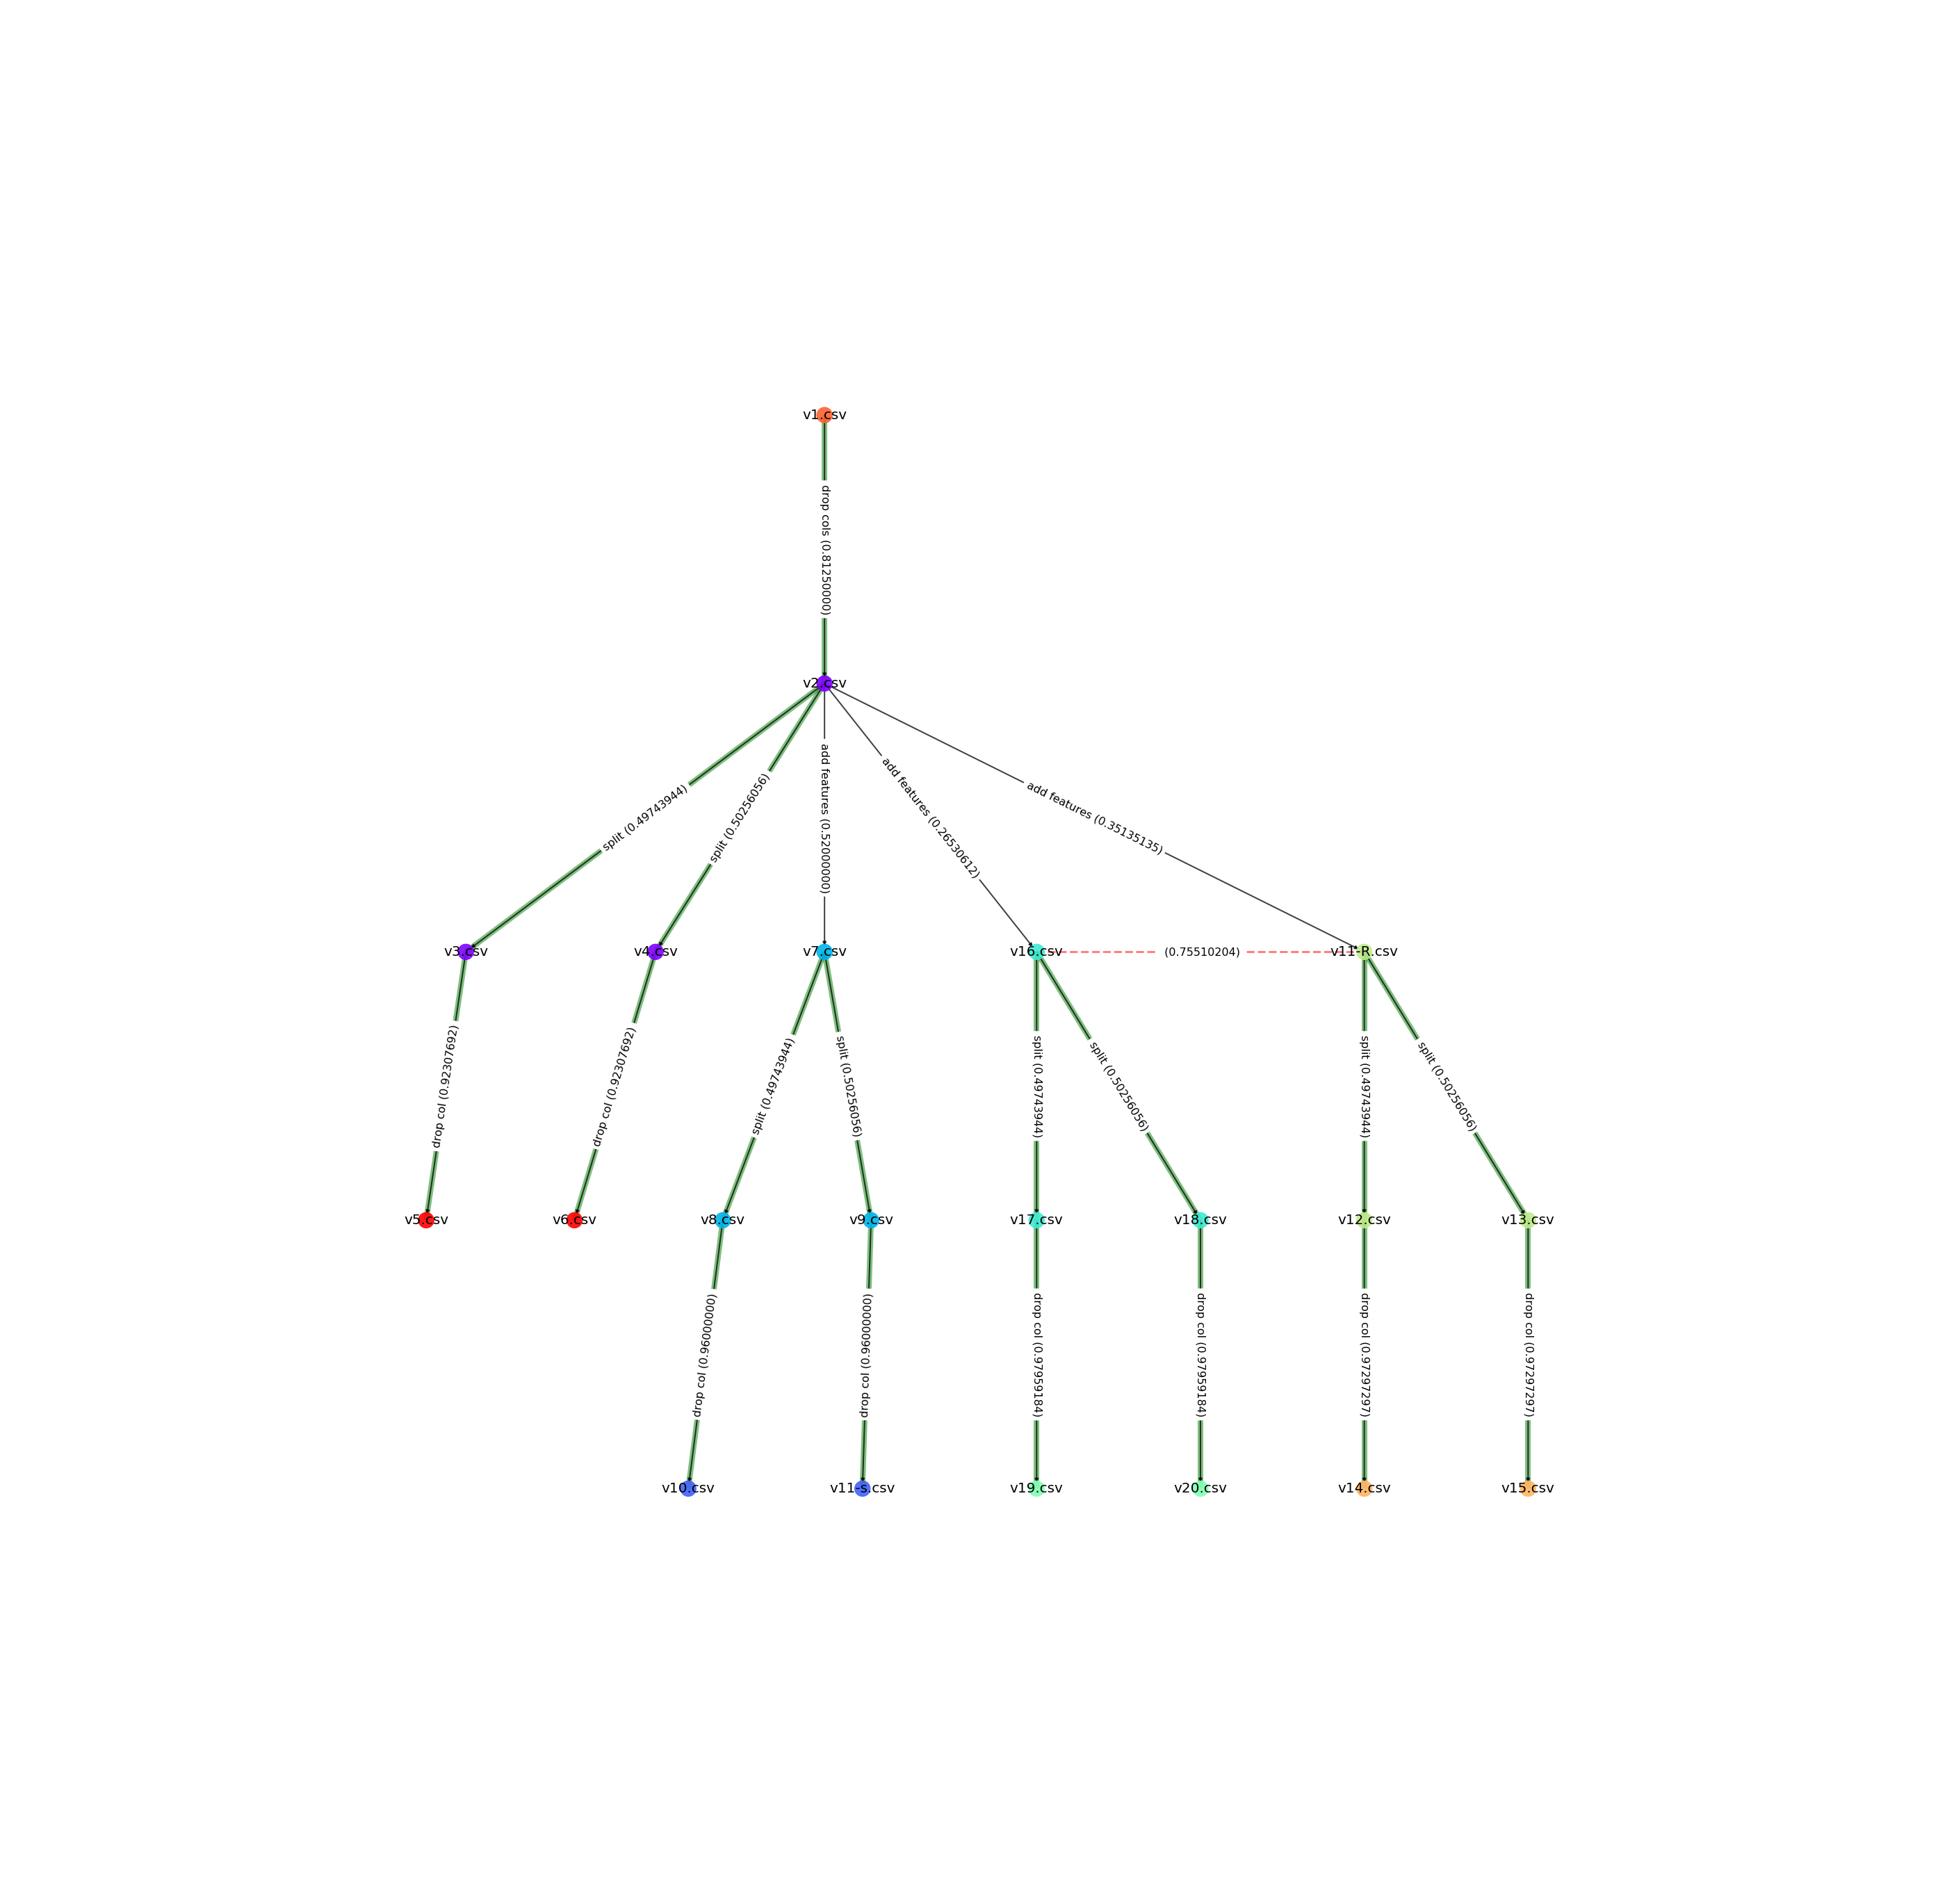

Adding edge v7.csv v11-R.csv 0.6756756756756757
Components: [{'v5.csv', 'v4.csv', 'v6.csv', 'v1.csv', 'v3.csv', 'v2.csv'}, {'v16.csv', 'v9.csv', 'v10.csv', 'v18.csv', 'v13.csv', 'v14.csv', 'v12.csv', 'v19.csv', 'v11-s.csv', 'v8.csv', 'v15.csv', 'v11-R.csv', 'v7.csv', 'v17.csv', 'v20.csv'}]
None

v5.csv


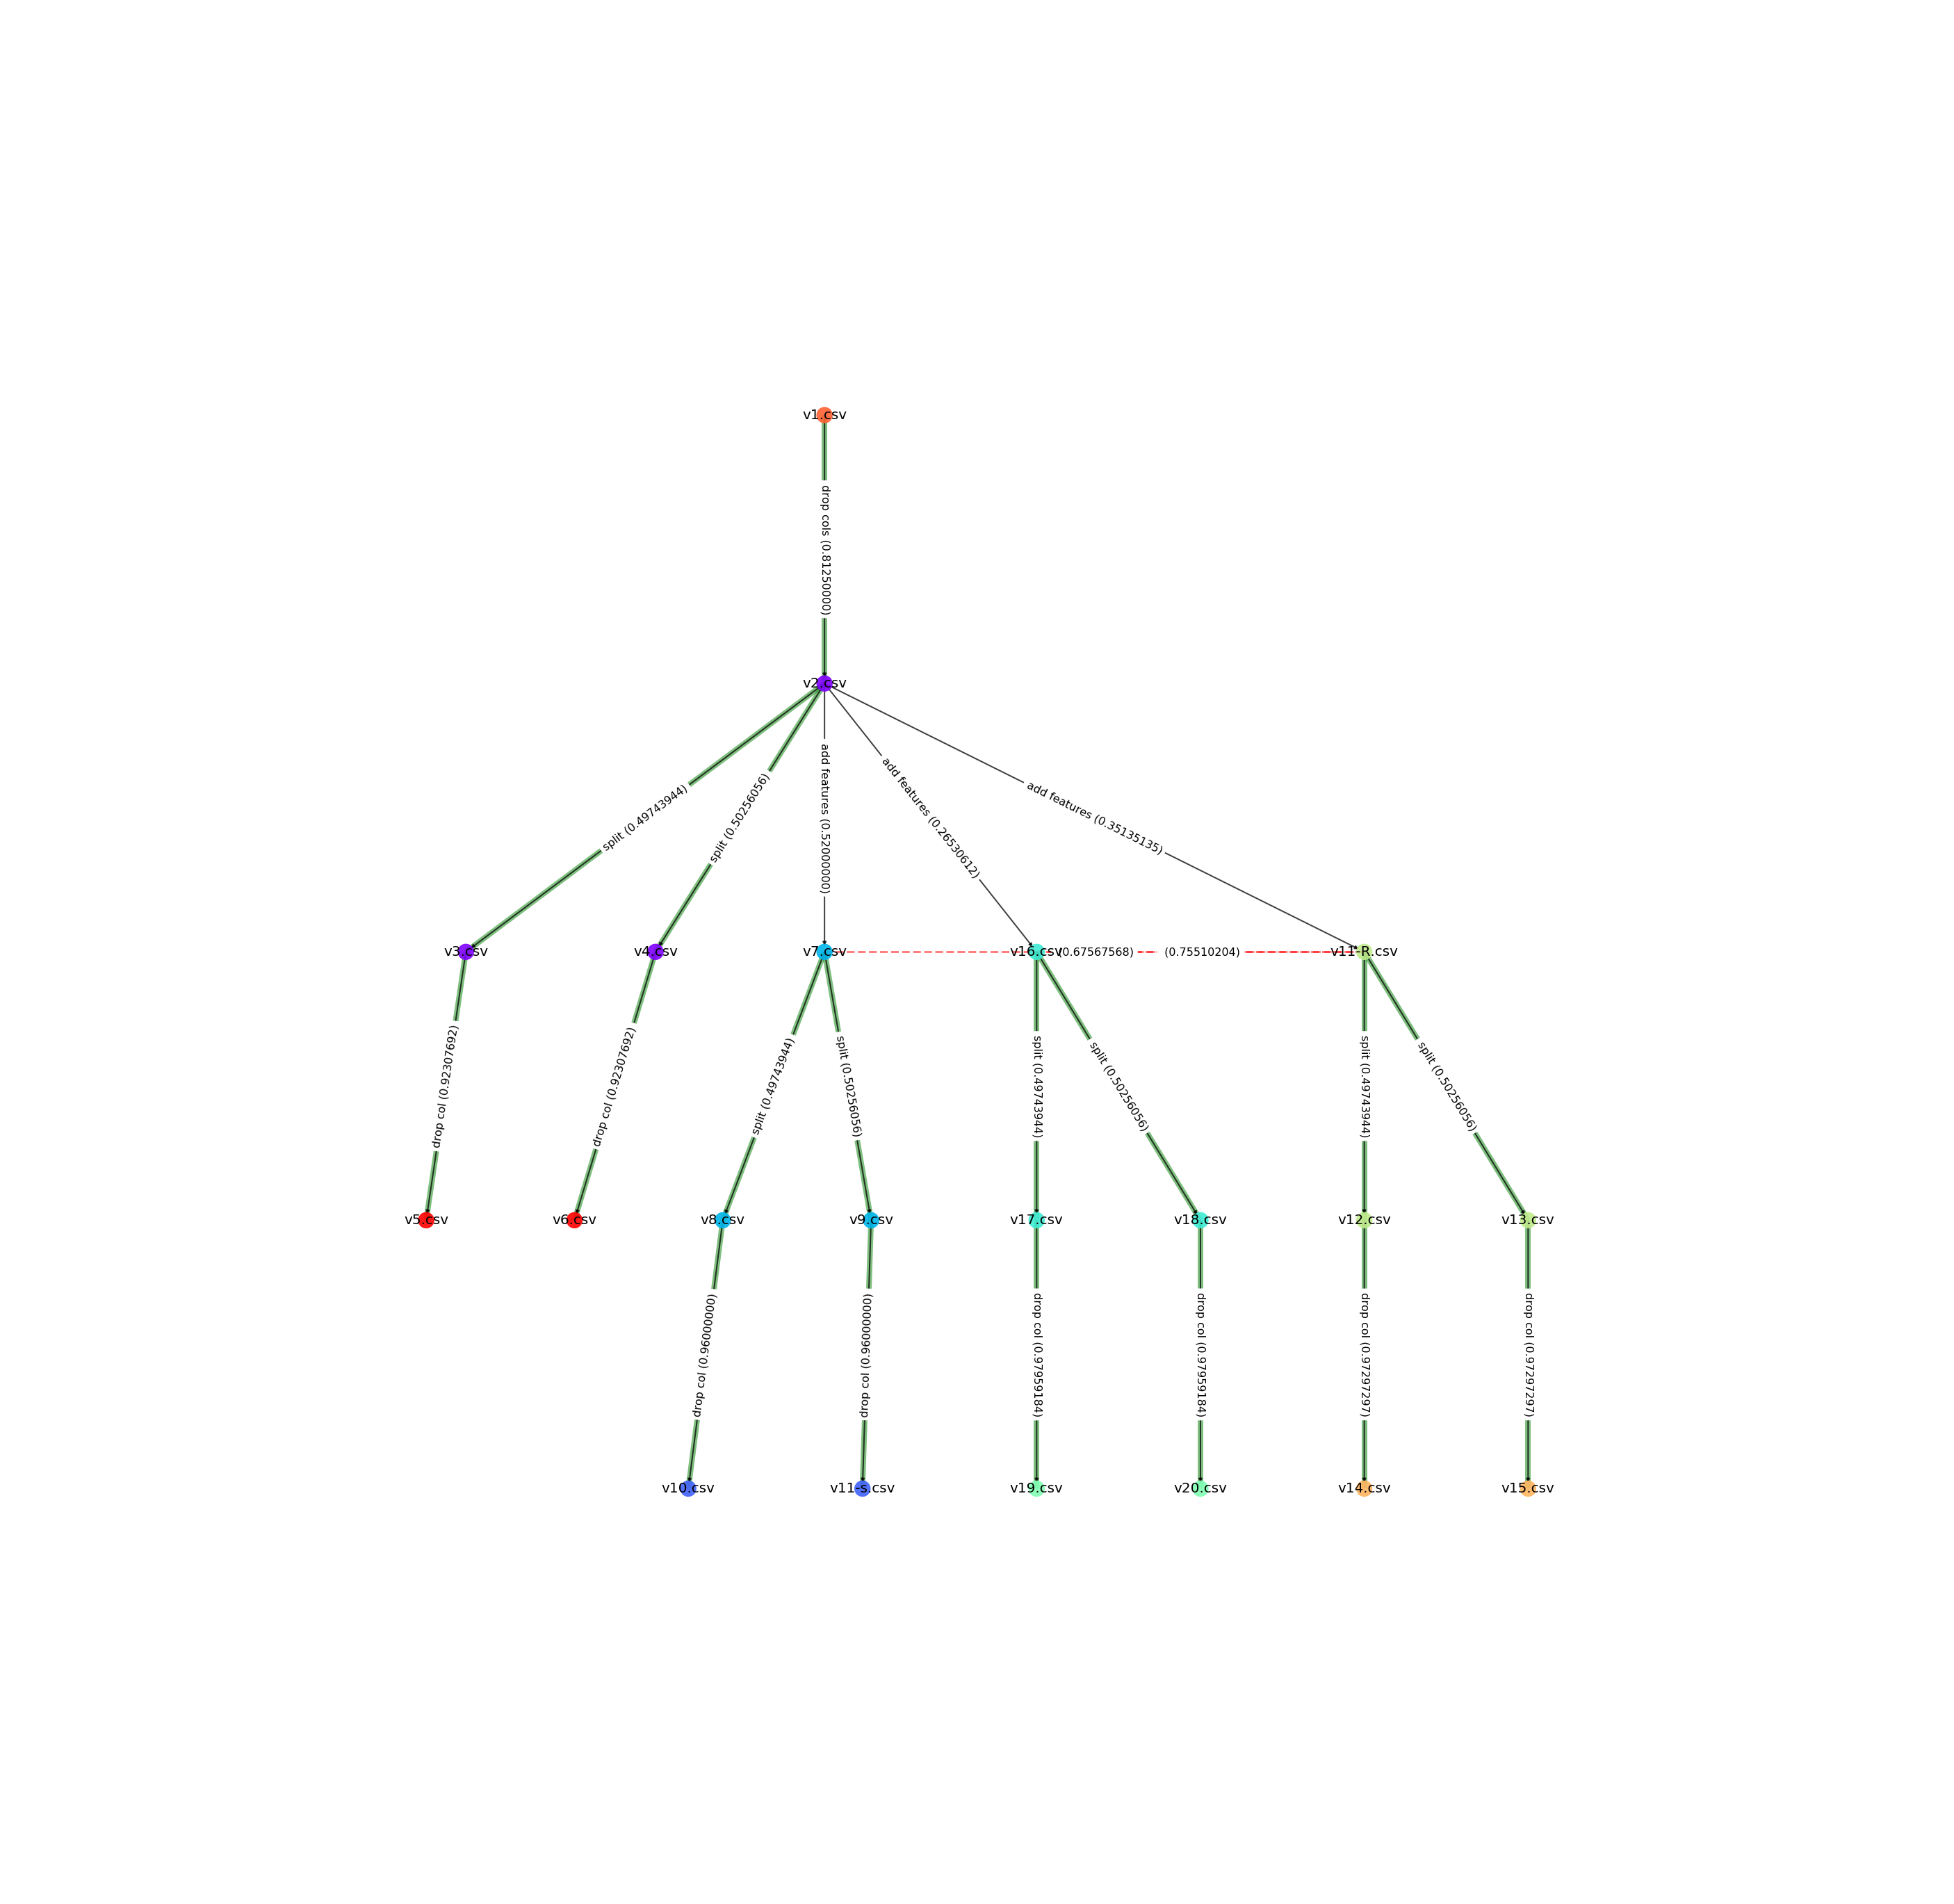

Adding edge v2.csv v7.csv 0.52
Components: [{'v9.csv', 'v14.csv', 'v11-s.csv', 'v11-R.csv', 'v7.csv', 'v5.csv', 'v16.csv', 'v13.csv', 'v4.csv', 'v6.csv', 'v8.csv', 'v17.csv', 'v2.csv', 'v10.csv', 'v15.csv', 'v3.csv', 'v20.csv', 'v18.csv', 'v12.csv', 'v19.csv', 'v1.csv'}]
None

v5.csv


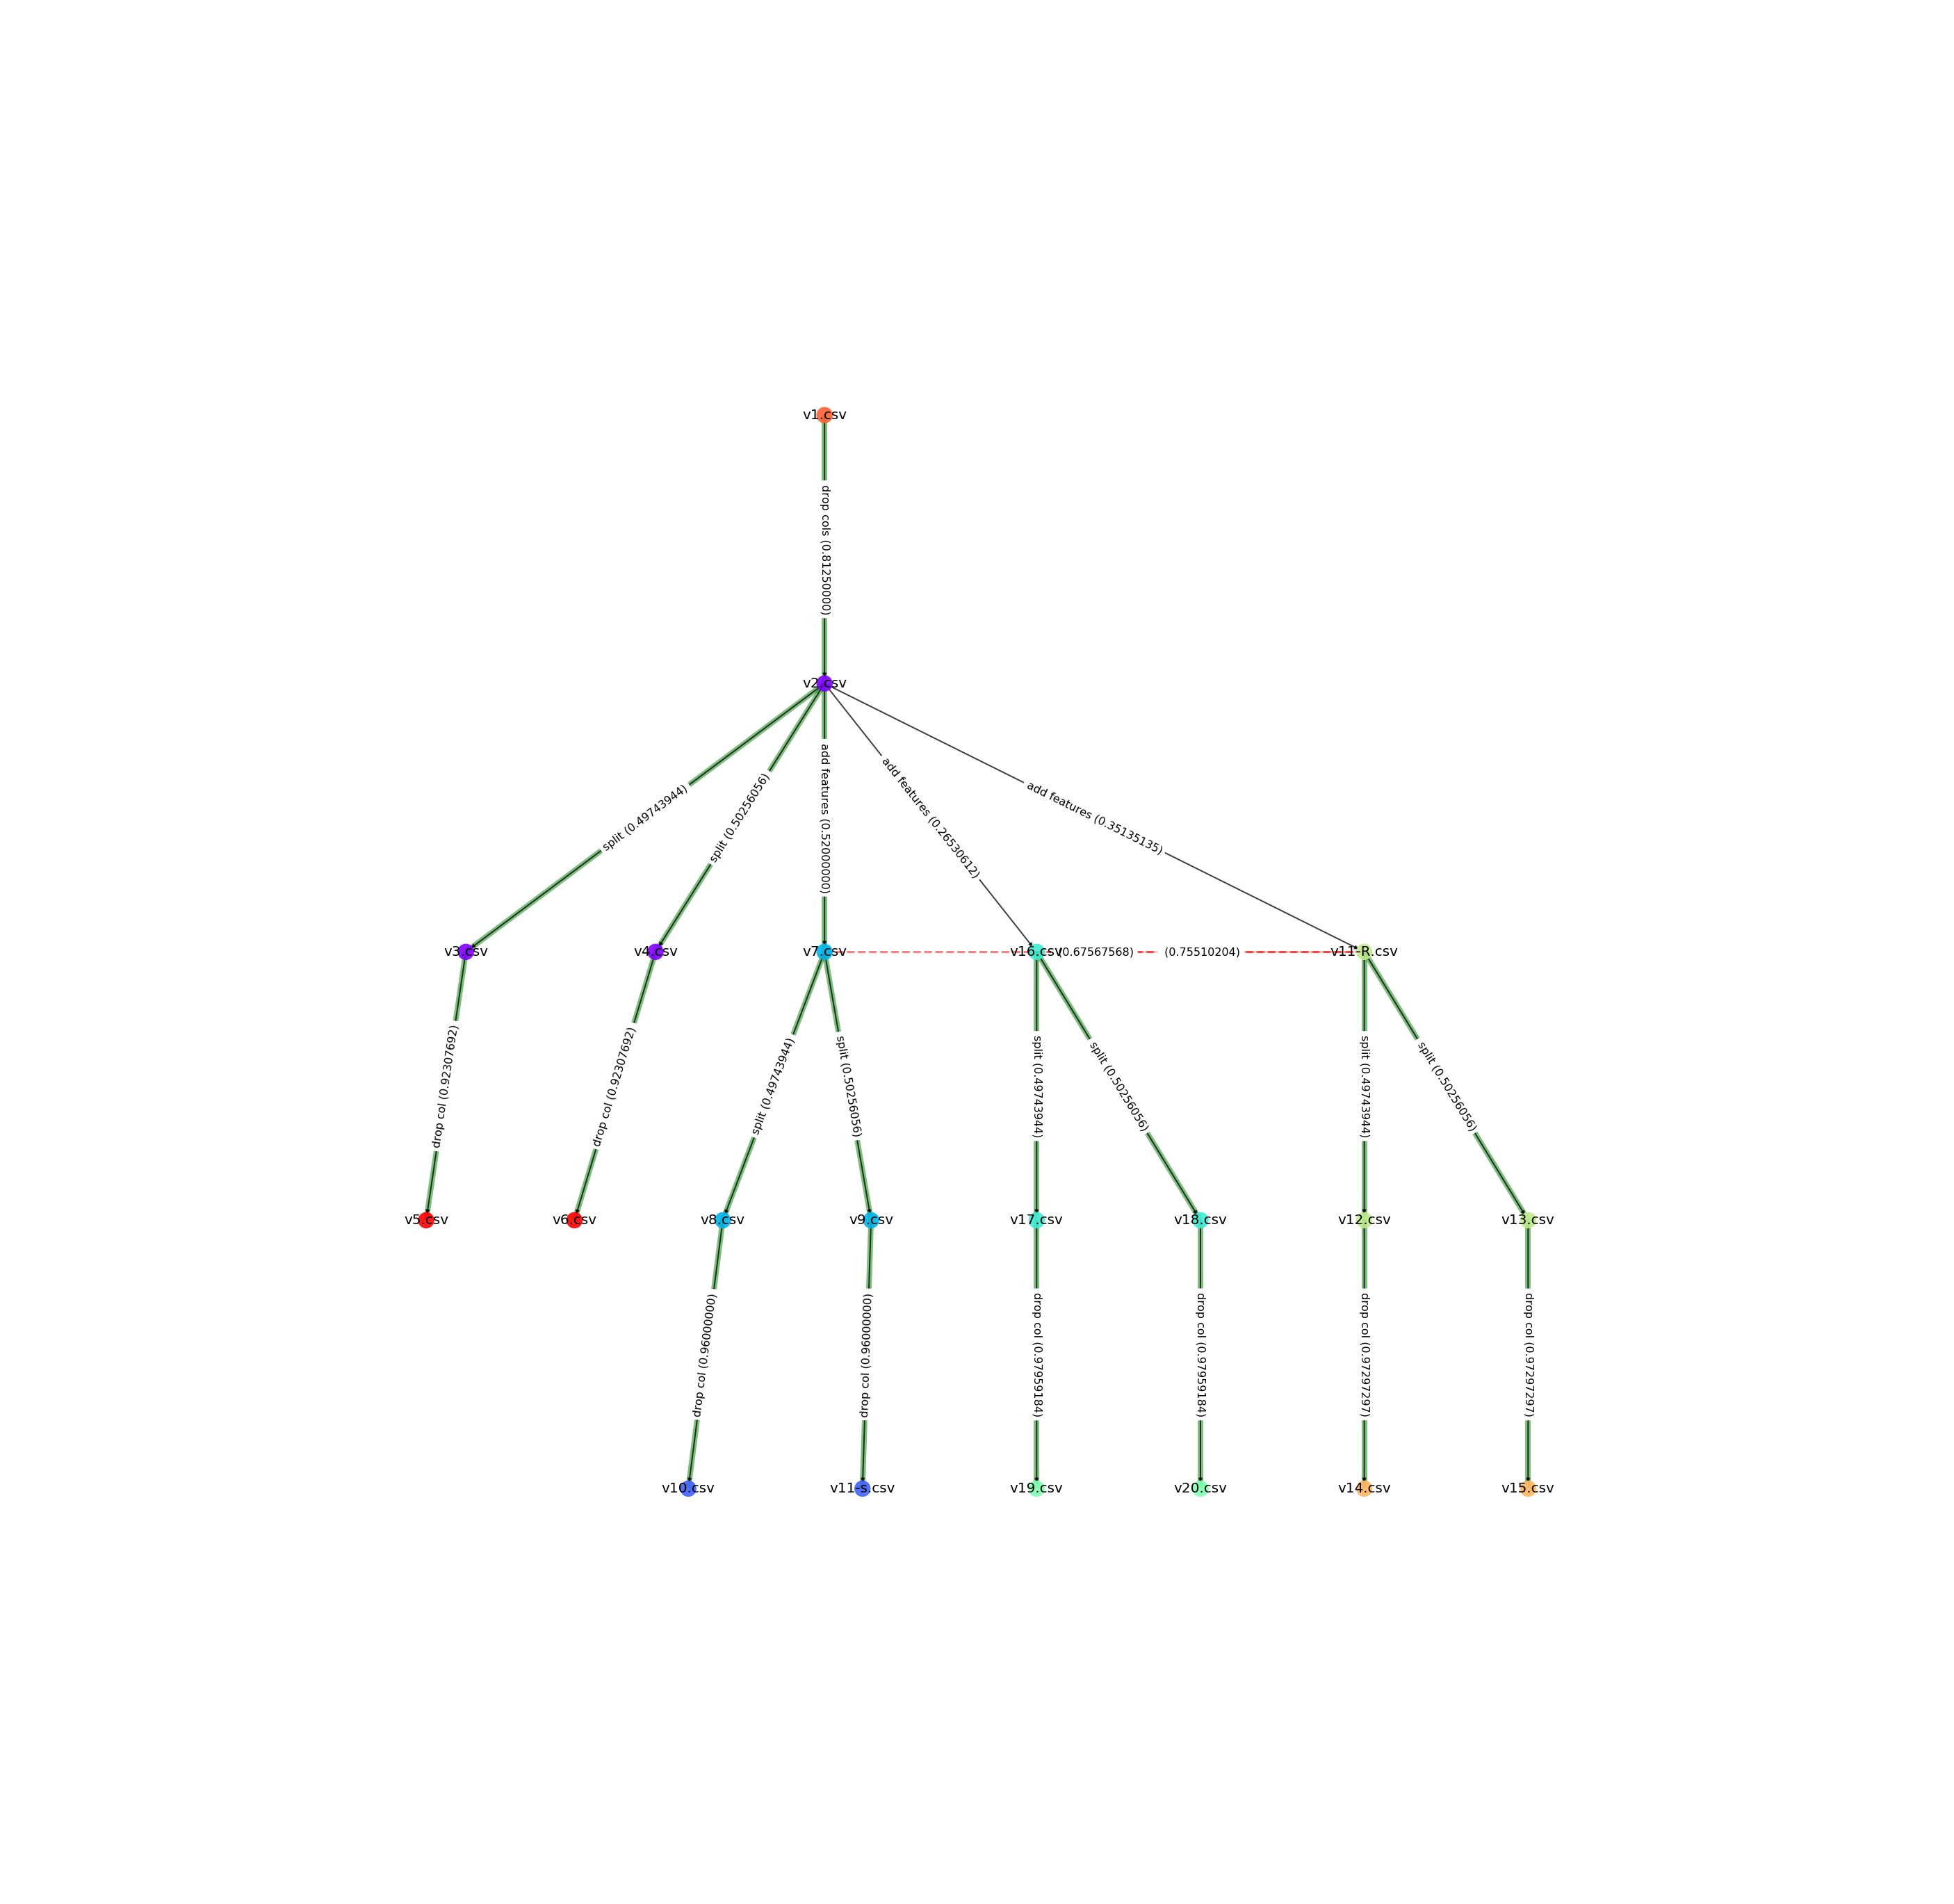

nb_name index numclusters distance_metric edges_correct edges_missing  \
0   retail  True           9     pandas_cell             8            12   
1   retail  True          12     pandas_cell             9            11   
2   retail  True          11     pandas_cell            10            10   
3   retail  True          10     pandas_cell            11             9   
4   retail  True           9     pandas_cell            12             8   
5   retail  True           8     pandas_cell            13             7   
6   retail  True           7     pandas_cell            14             6   
7   retail  True           6     pandas_cell            15             5   
8   retail  True           5     pandas_cell            16             4   
9   retail  True           4     pandas_cell            17             3   
10  retail  True           3     pandas_cell            17             3   
11  retail  True           2     pandas_cell            17             3   
12  retail  True           1     pandas_cell            18             2   

   edges_to_remove  join_edges  precision    recall        F1 missing_files  
0                0         NaN       0.40  1.000000  0.571429             0  
1                0         NaN       0.45  1.000000  0.620690             0  
2                0         NaN       0.50  1.000000  0.666667             0  
3                0         NaN       0.55  1.000000  0.709677             0  
4                0         NaN       0.60  1.000000  0.750000             0  
5                0         NaN       0.65  1.000000  0.787879             0  
6                0         NaN       0.70  1.000000  0.823529             0  
7                0         NaN       0.75  1.000000  0.857143             0  
8                0         NaN       0.80  1.000000  0.888889             0  
9                0         NaN       0.85  1.000000  0.918919             0  
10               1         NaN       0.85  0.944444  0.894737             0  
11               2         NaN       0.85  0.894737  0.871795             0  
12               2         NaN       0.90  0.900000  0.900000             0

In [69]:
df = lineage_inference_agglomerative(nb_name=NB_NAME)
df

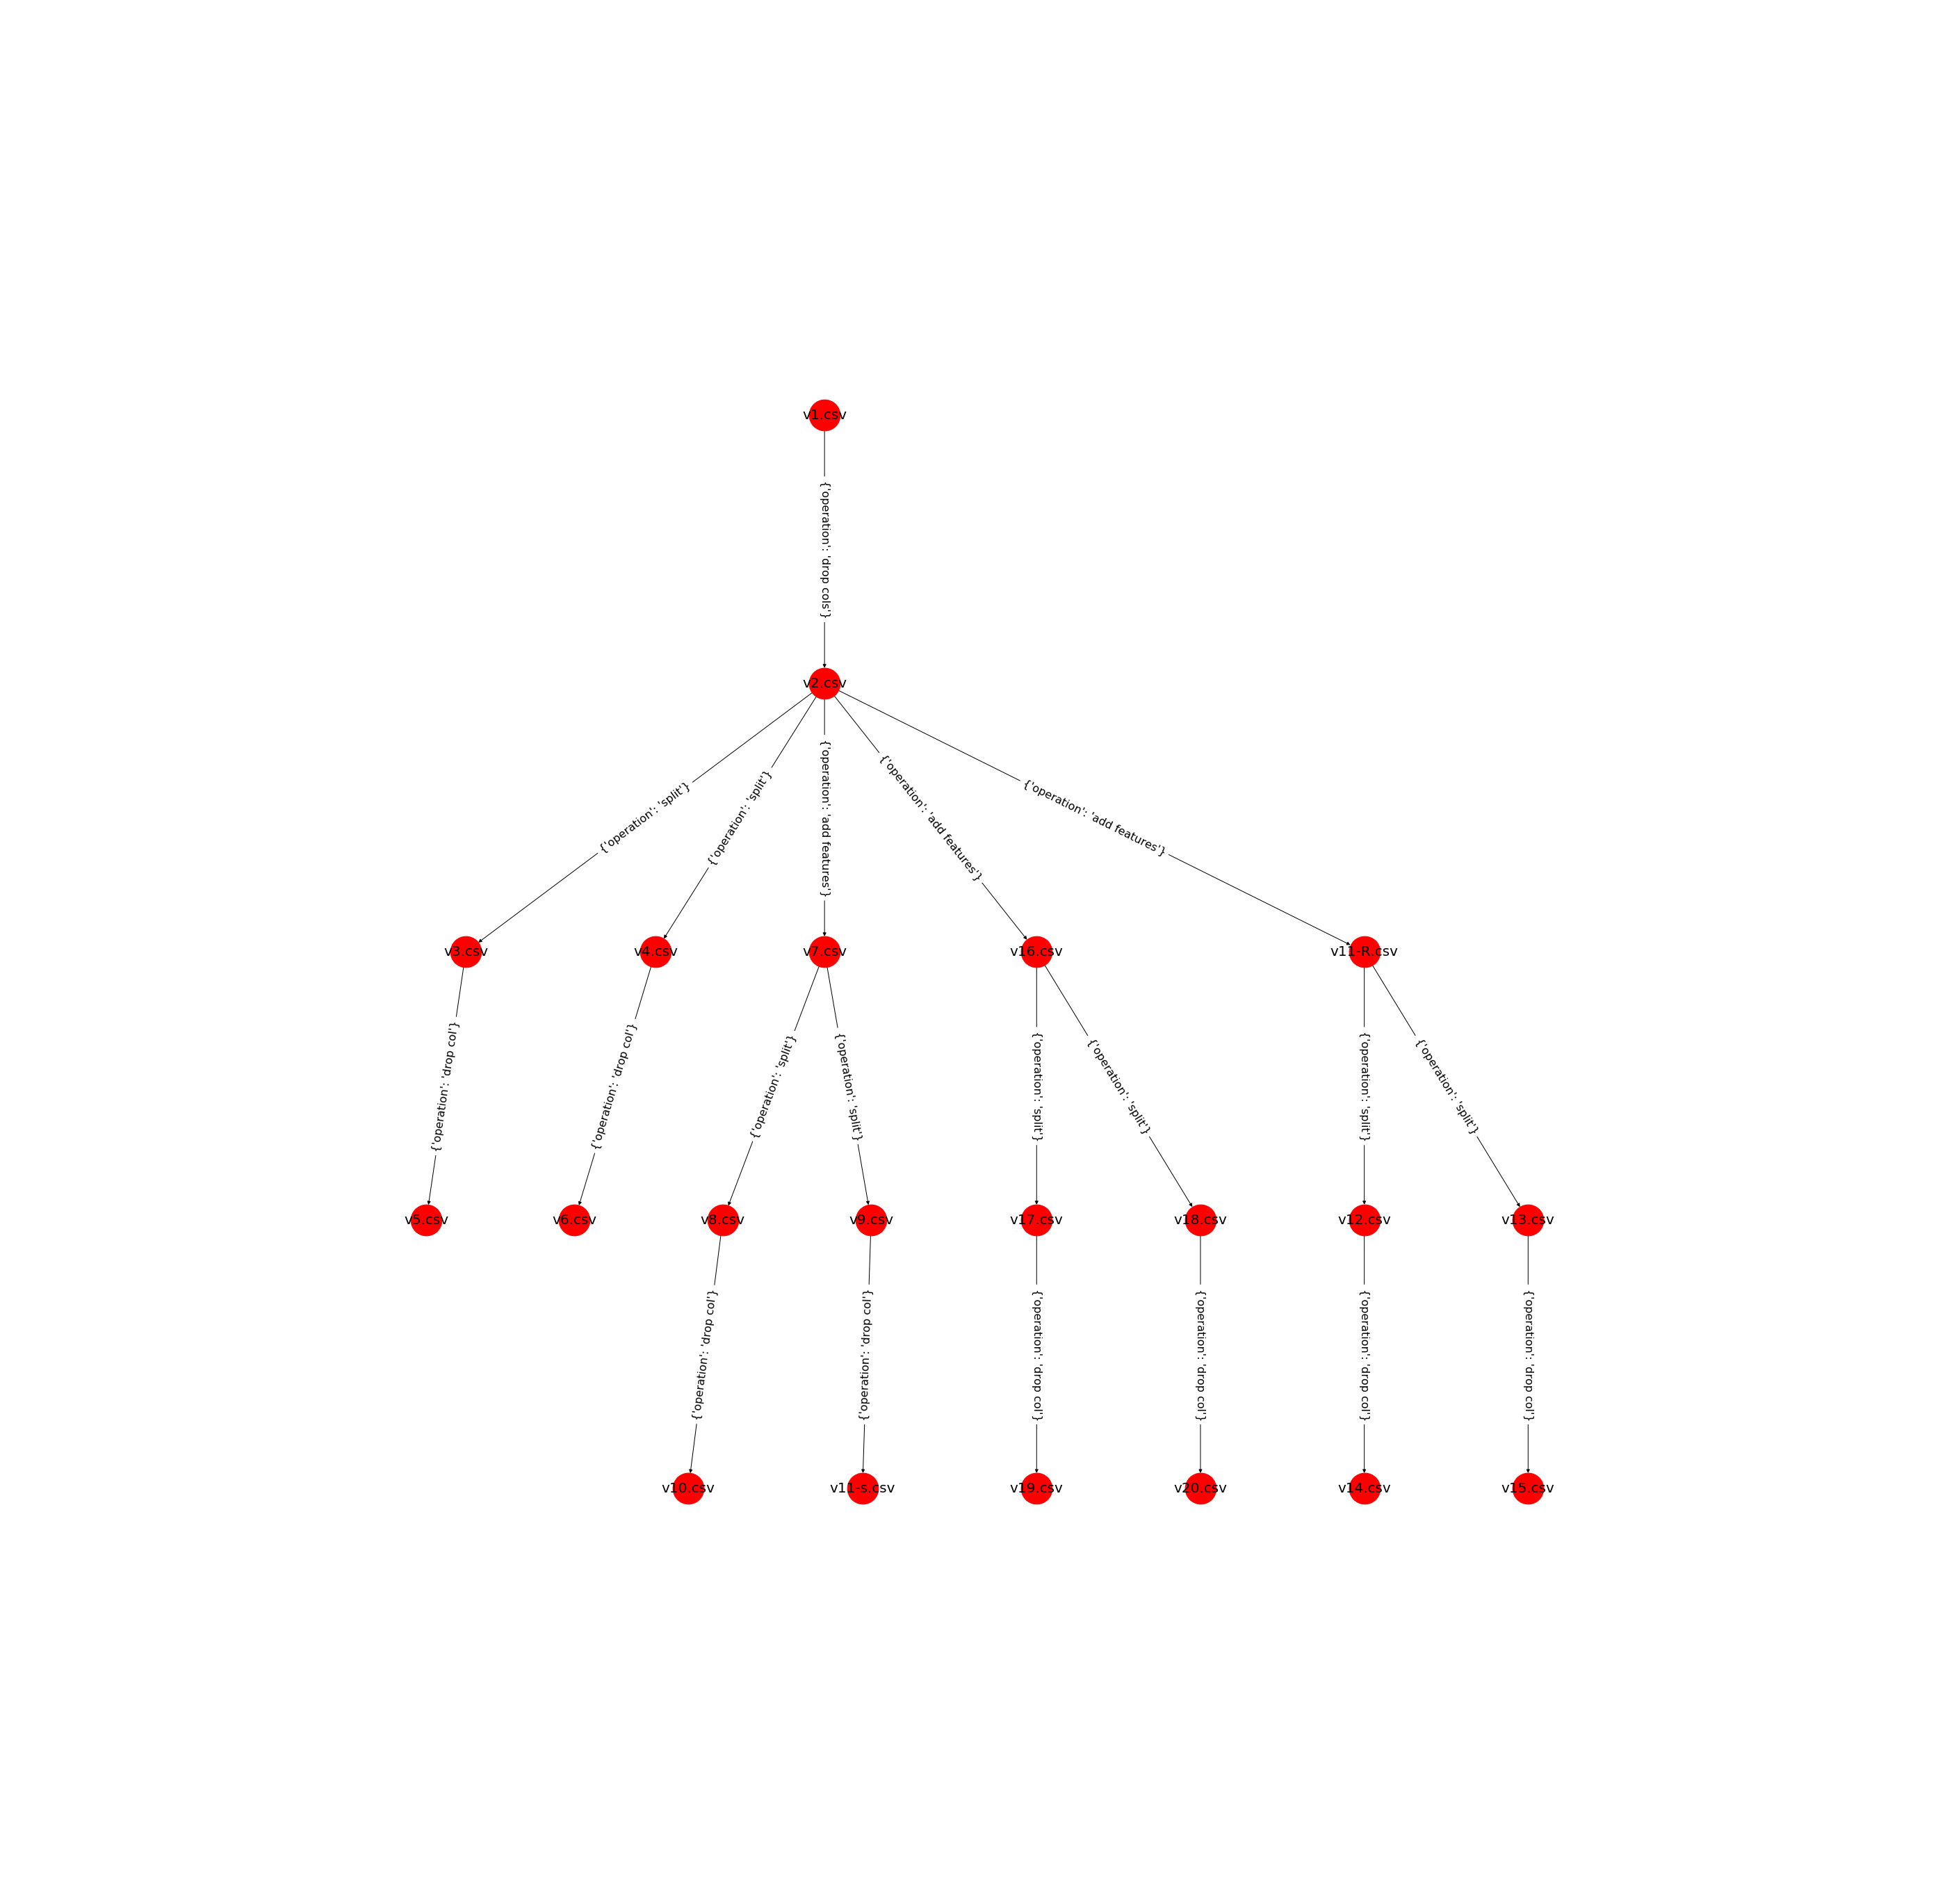

<module 'matplotlib.pyplot' from '/home/suhail/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [7]:
# Load Ground Truth:
g_truth = nx.read_gpickle(BASE_DIR+NB_NAME+'/'+NB_NAME+'_gt_fixed.pkl')
graphs.draw_graph(g_truth, canvas_size=(50,50))

In [58]:
schema_dict

defaultdict(list,
            {frozenset({'Area',
                        'Broad Outcome',
                        'Crime Month',
                        'Crime type',
                        'Outcome Month',
                        'Outcome type'}): ['crimes__2.csv', 'typeOutcome.csv'],
             frozenset({'Area',
                        'Crime Month',
                        'Crime type',
                        'Outcome Month',
                        'Outcome type'}): ['locationRecode.csv',
              'crimeTypes.csv',
              'areaCrime__1.csv',
              'typeLoc__2.csv',
              'crimesByMonth.csv',
              'areaCrime__3.csv',
              'crimes.csv',
              'areaCrime__2.csv',
              'typeLoc.csv',
              'areaCrime.csv',
              'crimeTypes__1.csv',
              'typeLoc__3.csv'],
             frozenset({'Area',
                        'Crime Month',
                        'Crime type',
                        'Outco

In [70]:
from PIL import Image

image_frames = [Image.open(frame) for frame in img_frames]

In [71]:
image_frames[0].save('retail.gif', 
                     format='GIF', append_images=image_frames[1:], 
                     save_all=True,
                     duration=1000, 
                     loop=0)

In [ ]:
df[['numclusters', 'edges_correct','edges_missing', 'edges_to_remove', 'F1']][:-1]
